In [39]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils

import cv2

from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Dataset info

In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'
response_str = '%s_resptest-%s_respthr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)


#### Experiment to decode
experiment = 'blobs'
stim_filterby = 'first'
has_gratings = False


dff_resptest-nstds_respthr-10.00


# Output dir

In [5]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

decoding_dir = os.path.join(aggregate_dir, 'decoding')
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding


# Get metadata for experiment type

In [6]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                26
Lm                22
V1                18

# Exclude datasets without RFs

In [7]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
sdata_exp[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                13
Lm                12
V1                11

# Drop duplicates and whatnot fovs

In [8]:
if experiment=='blobs':
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, 
                                       has_gratings=has_gratings, as_dict=True)
else:
    g_str = 'gratingsonly'
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)
filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [9]:
print(filter_str)
for k, v in exp_dkeys.items():
    print('... %s: %i datasets' % (k, len(v)))

# Get the datakeys from dict
dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]

# Reformat datakeys from list (e.g., YYYYMMDD_ANIMALID_fov1)
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) 
                         & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) 
                 for s in dictkeys]

# Reassemble dict 
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) 
               for k, v in exp_dkeys.items())

stim-filter-first_blobsonly_dff_resptest-nstds_respthr-10.00
... V1: 8 datasets
... Lm: 8 datasets
... Li: 9 datasets


In [10]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_resptest-nstds_respthr-10.00


# Load neural responses

In [11]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s-thr-%.2f*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, responsive_thr, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


## Check that all datasets have same stim configs

In [12]:
SDF={}
for datakey in stim_datakeys:
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid, verbose=False)
    sdf = obj.get_stimuli()
    SDF[datakey] = sdf

nonpos_params = [p for p in sdf.columns if p not in ['xpos', 'ypos', 'position']] 
assert all([all(sdf[nonpos_params]==d[nonpos_params]) for k, d in SDF.items()]), "Incorrect stimuli..."

# Get screen and stimulus info

In [218]:
reload(putils)

<module 'pipeline.python.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/utils.py'>

In [219]:
screeninfo = putils.get_screen_dims() #aggr.get_aggregate_stimulation_info(curr_sdata) #, experiment='blobs')
screenright = float(screeninfo['azimuth_deg']/2)
screenleft = -1*screenright #float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['altitude_deg']/2)
screenbottom = -1*screentop
screenaspect = float(screeninfo['resolution'][0]) / float(screeninfo['resolution'][1])
screeninfo

{'altitude_cm': 58.0,
 'altitude_deg': 67.323,
 'azimuth_cm': 103.0,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

# Load RF fits

In [14]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [27]:
#### Load RF fits -------------------------------------
rf_filter_by=None
reliable_only = True
rf_fit_thr = 0.05
# -----------------------------------------------------
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str, rf_filter_by, reliable_str)

('matchblobs_reliable', None, 'reliable')


In [28]:
# Get position info for RFs 
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', 
                           '%s__%s' % (traceid, fit_desc))
df_fpath =  os.path.join(aggr_rf_dir, 
                            'fits_and_coords_%s_%s.pkl' % (rf_filter_by, reliable_str))
print(df_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl


In [22]:
glob.glob(os.path.join(aggr_rf_dir, '*.pkl'))

['/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_rfs10.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_r_df.pkl']

In [29]:
rfdf = dutils.get_rf_positions(rf_dsets, df_fpath)

N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
Loading existing RF coord conversions...


In [33]:
rfdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    24
Lm    21
V1    16
Name: visual_area, dtype: int64

# Select RFs

In [34]:
# Select RFs, whichever (rfs/rfs10) in common with blob rids
RFs = dutils.pick_rfs_with_most_overlap(rfdf, MEANS)

print("All RFs-----------------------------------")
pp.pprint(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print("RFs with blobs -----------------------------------")
pp.pprint(RFs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


20190613_JC097_fov1: Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
20190622_JC085_fov1: Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
20190618_JC097_fov1: Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
20190602_JC091_fov1: Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
20190616_JC097_fov1: Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
20191006_JC110_fov1: Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)
All RFs-----------------------------------
             datakey
visual_area         
Li                24
Lm                21
V1                16
RFs with blobs -----------------------------------
             datakey
visual_area         
Li                13
Lm                12
V1                11


# Plot

<IPython.core.display.Javascript object>


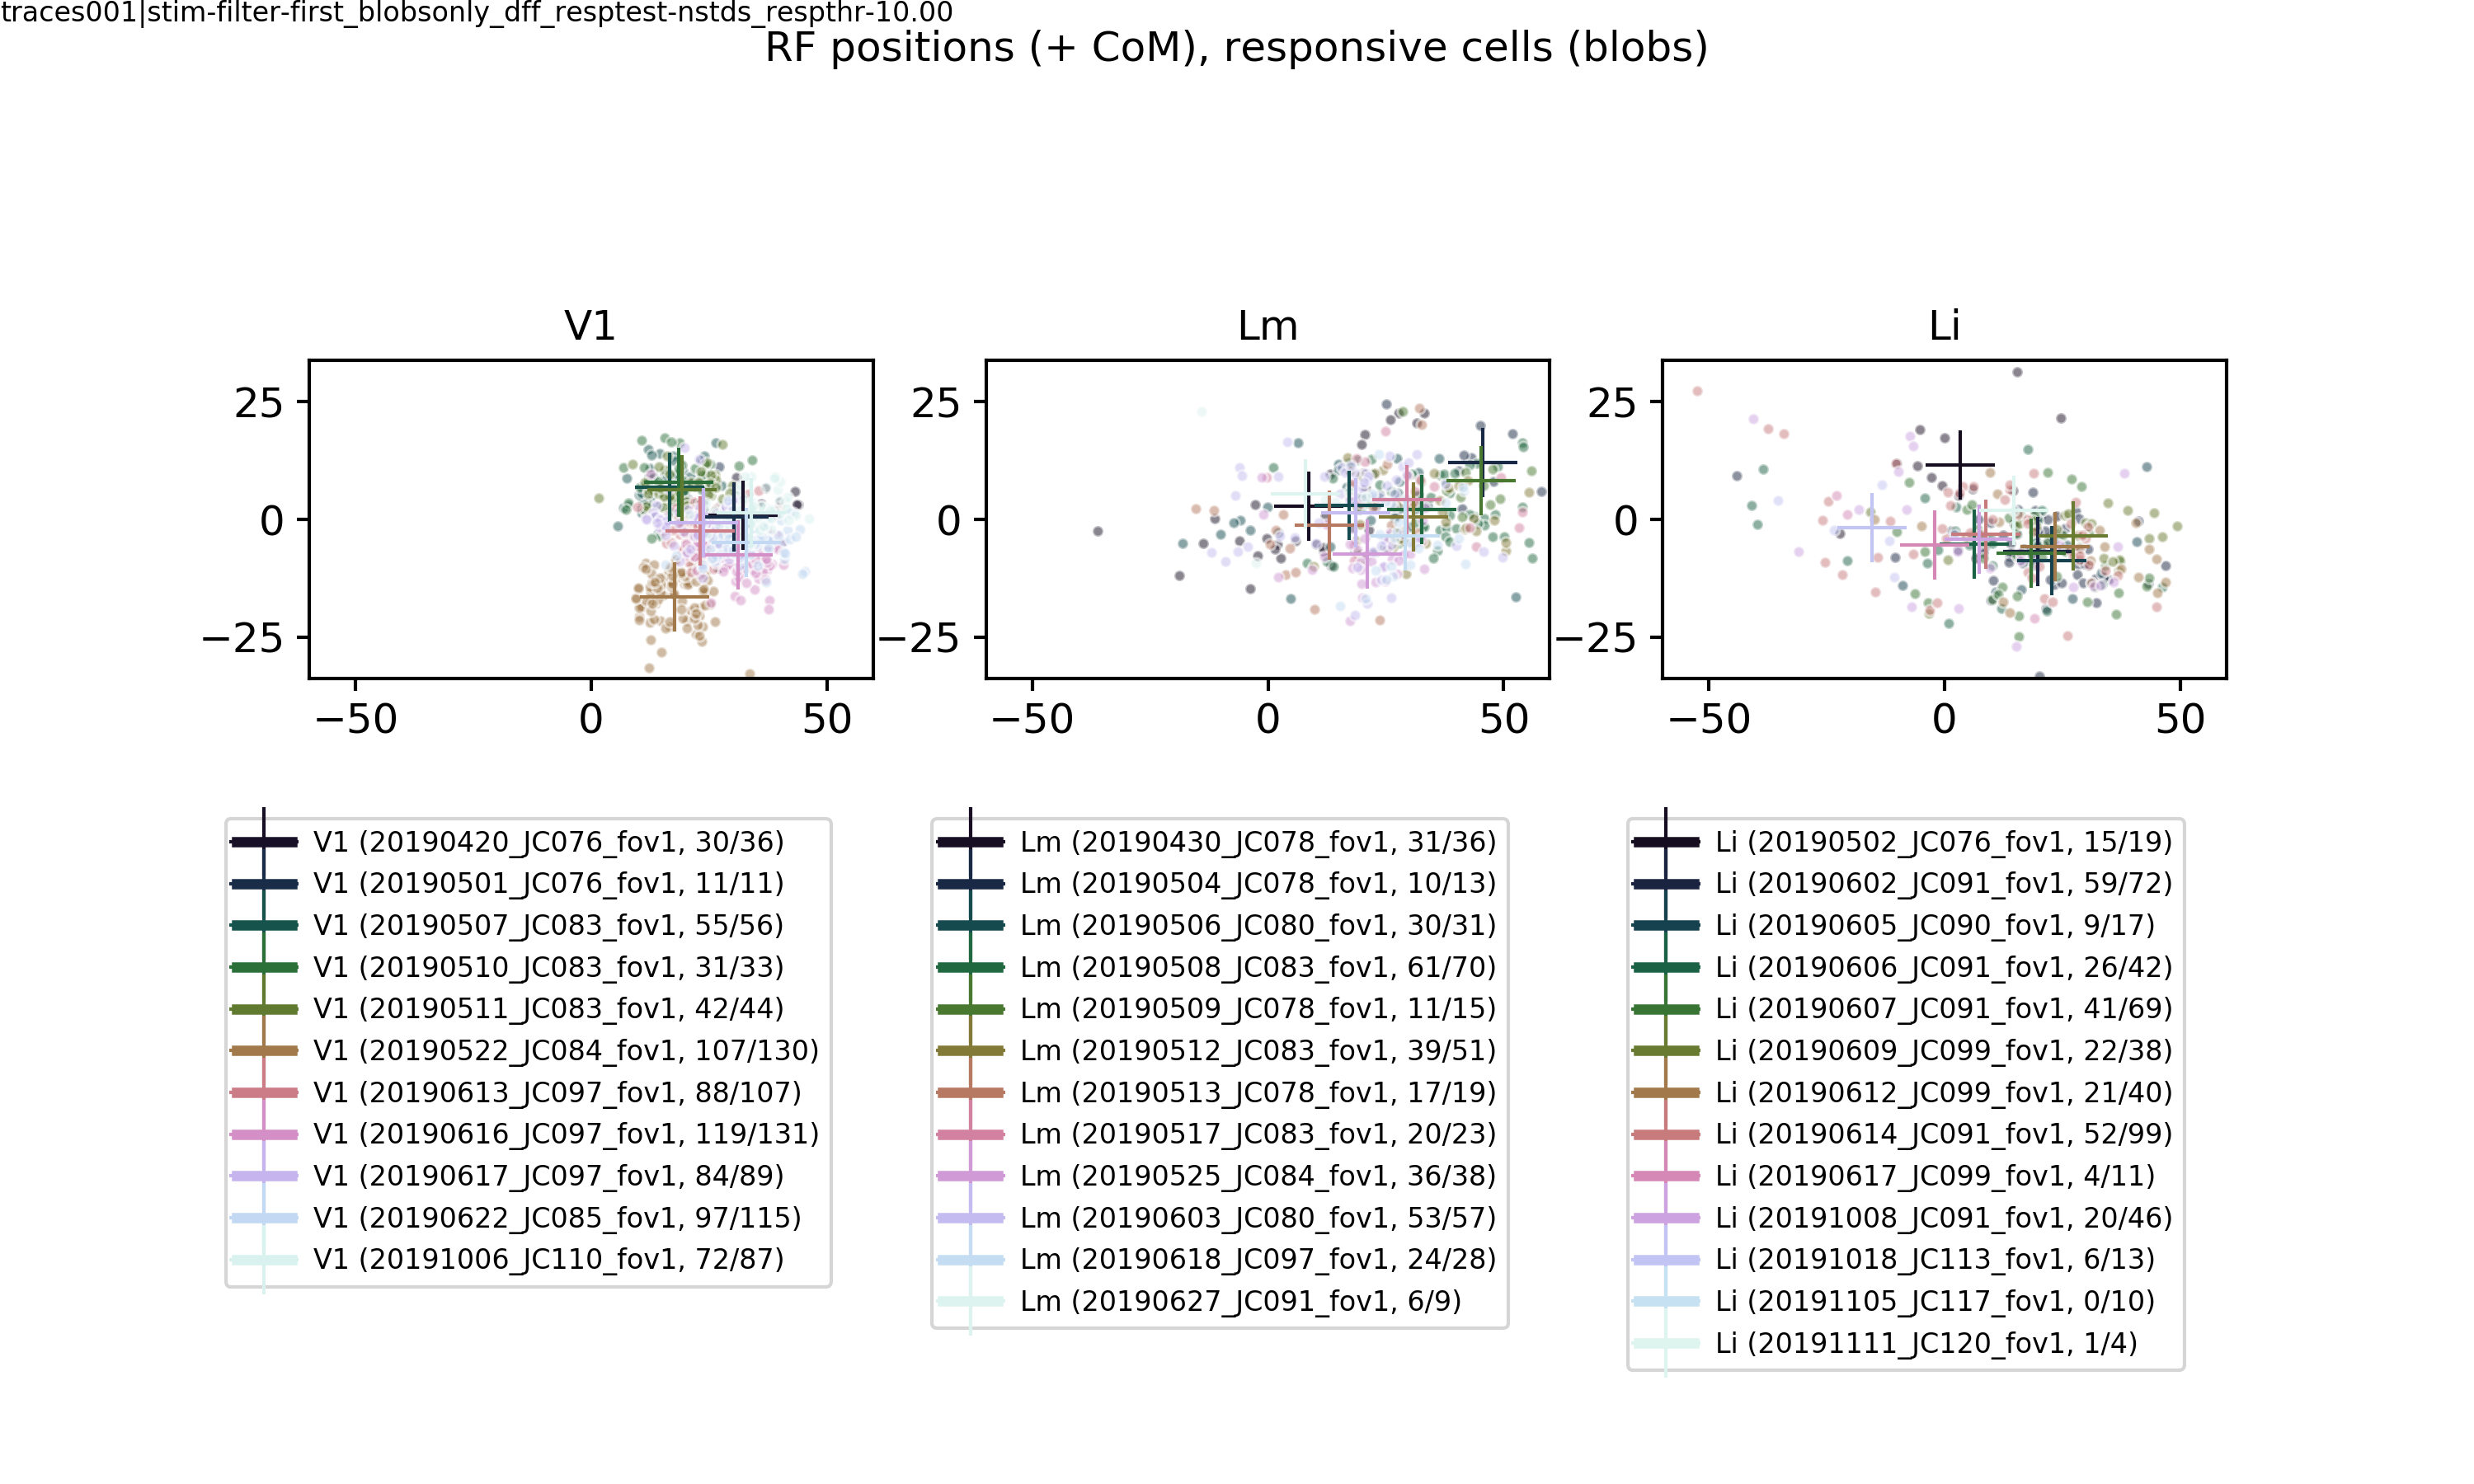

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff', 'CoM_label-fovs_common_to_blobs_and_rfs_None_reliable')


In [35]:
# Plot
fig = dutils.plot_all_rfs(RFs, MEANS, screeninfo, cmap='cubehelix')
pl.suptitle("RF positions (+ CoM), responsive cells (%s)" % experiment)
putils.label_figure(fig, data_id)
figname = 'CoM_label-fovs_common_to_blobs_and_rfs_%s_%s' % (rf_filter_by, reliable_str) 
pl.savefig(os.path.join(aggr_rf_dir, '%s.svg' % figname))
print(aggr_rf_dir, figname)

# Calculate overlap with stimulus

#### Test with example FOV

In [36]:
experiment = 'blobs'

# TEST
animalid = 'JC097'
session = '20190616'
fovnum = 1

datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
print(datakey)
S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

20190616_JC097_fov1
Stimuli presented at coords: (25, -5)


In [37]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

curr_rfs = RFs[RFs['datakey']==datakey].copy()

# Convert RF fit params to polygon
curr_rfs.index = curr_rfs['cell'].values
rf_polys = rfutils.rfs_to_polys(curr_rfs[rf_fit_params])

# Convert stimuli to polyon bounding boxes
stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
# Concatenate into dataframe
perc_overlap = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})

<IPython.core.display.Javascript object>


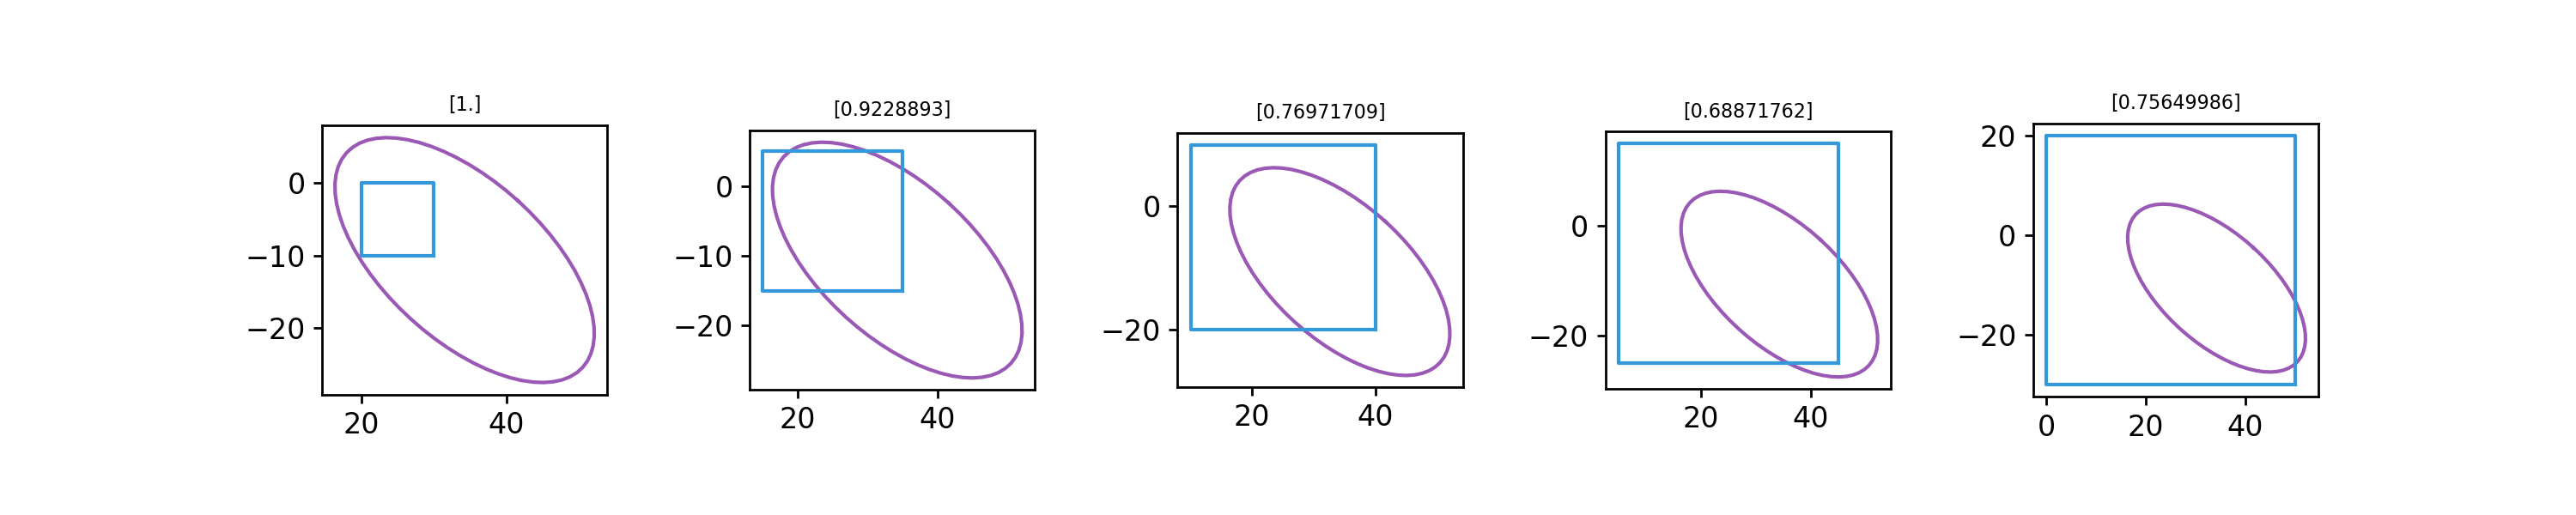

(0, array([1.]))
(1, array([0.9228893]))
(2, array([0.76971709]))
(3, array([0.68871762]))
(4, array([0.75649986]))


In [38]:
fig, axn = pl.subplots(1,5, figsize=(15,3))

p_rf = rf_polys[0][1]

p_stim = stim_polys[0]
for stim_ix, p_stim in enumerate(stim_polys):
    ax = axn[stim_ix]

    #perc_overlap = rfutils.get_proportion_overlap(rf_polys[0], (stim_ix, p_stim))
    perc_overlap = rfutils.get_proportion_overlap(rf_poly, p_stim) 
    
    #print(perc_overlap)rfutils.get_proportion_overlap(rf_poly, stim_poly)

    x, y = p_rf.exterior.xy
    ax.plot(x, y)
    ax.set_title(perc_overlap['perc_overlap'].values, fontsize=8)
    print(stim_ix, perc_overlap['perc_overlap'].values)

    x, y = p_stim[1].exterior.xy
    ax.plot(x, y)
    ax.set_aspect('equal')
    
pl.subplots_adjust(wspace=0.5)

In [40]:
def resize_image_to_coords(im, size_deg=30, pix_per_deg=16.05, aspect_scale=1.747):
    print(pix_per_deg)
    ref_dim = max(im.shape)
    resize_factor = ((size_deg*pix_per_deg) / ref_dim ) / pix_per_deg
    scale_factor = resize_factor * aspect_scale
    
    imr = cv2.resize(im, None, fx=scale_factor, fy=scale_factor)
    
    return imr

In [41]:
def place_stimulus_on_screen(im, extent, resolution=[1080, 1920]):
    lin_x, lin_y = putils.get_lin_coords(resolution=res)
    
    xx, yy = np.where(abs(lin_x-extent[0])==abs(lin_x-extent[0]).min())
    xmin=int(np.unique(yy))

    xx, yy = np.where(abs(lin_x-extent[1])==abs(lin_x-extent[1]).min())
    xmax=int(np.unique(yy))

    xx, yy = np.where(abs(lin_y-extent[2])==abs(lin_y-extent[2]).min())
    ymin = res[0] - int(np.unique(xx))

    xx, yy = np.where(abs(lin_y-extent[3])==abs(lin_y-extent[3]).min())
    ymax = res[0] - int(np.unique(xx))

    print(extent)
    print([xmin, xmax, ymin, ymax])

    nw = xmax - xmin
    nh = ymax - ymin
    im_r2 = cv2.resize(im, (nw, nh))

    sim_screen = np.zeros(lin_x.shape)
    sim_screen[ymin:ymax, xmin:xmax] = np.flipud(im_r2)

    return sim_screen

In [42]:
def convert_fitparams_to_pixels(rid, curr_rfs, pix_per_deg=16.06,
                                resolution=[1080, 1920],
                                convert_params=['x0', 'y0', 'fwhm_x', 'fwhm_y', 'std_x', 'std_y']):
    
    lin_x, lin_y = putils.get_lin_coords(resolution=res)

    # Get position
    ctx = curr_rfs['x0'][rid]
    cty = curr_rfs['y0'][rid]

    # Convert to deg
    _, yy = np.where(abs(lin_x-ctx)==abs(lin_x-ctx).min())
    x0=int(np.unique(yy))
    xx, _ = np.where(abs(lin_y-cty)==abs(lin_y-cty).min())
    y0=res[0]-int(np.unique(xx))

    # Get sigmax-y:
    theta = 60 #np.rad2deg(curr_rfs['theta'][rid])
    sigx = curr_rfs['fwhm_x'][rid]
    sigy = curr_rfs['fwhm_y'][rid]

    sz_x = sigx*pix_per_deg*.5
    sz_y = sigy*pix_per_deg*.5
    
    theta = curr_rfs['theta'][rid]
    
    return x0, y0, sz_x, sz_y, theta


In [62]:
def load_stimuli(root='/n/home00/juliana.rhee', 
                 stimulus_path='Repositories/protocols/physiology/stimuli/images'):

    stimulus_dir = os.path.join(root, stimulus_path)
    # stimulus_dir = '/n/home00/juliana.rhee/Repositories/protocols/physiology/stimuli/images'

    # Get image paths:
    #object_list = ['D1', 'D2']
    object_list = ['D1', 'M14', 'M27', 'M53', 'M66', 'M9', 'M93', 'D2']
    
    image_paths = []
    for obj in object_list:
        stimulus_type = 'Blob_%s_Rot_y_fine' % obj
        image_paths.extend(glob.glob(os.path.join(stimulus_dir, stimulus_type, '*_y0.png')))
    print("%i images found for %i objects" % (len(image_paths), len(object_list)))
    assert len(image_paths)>0, "No stimuli in:\n  %s" % stimulus_dir
    images = {}
    for object_name, impath in zip(object_list, image_paths):
        im = cv2.imread(impath)
        images[object_name] = im[:, :, 0]
    print("im shape:", images['D1'].shape)
    
    return images

8 images found for 8 objects
('im shape:', (618, 1080))
('im shape:', (618, 1080))


<IPython.core.display.Javascript object>


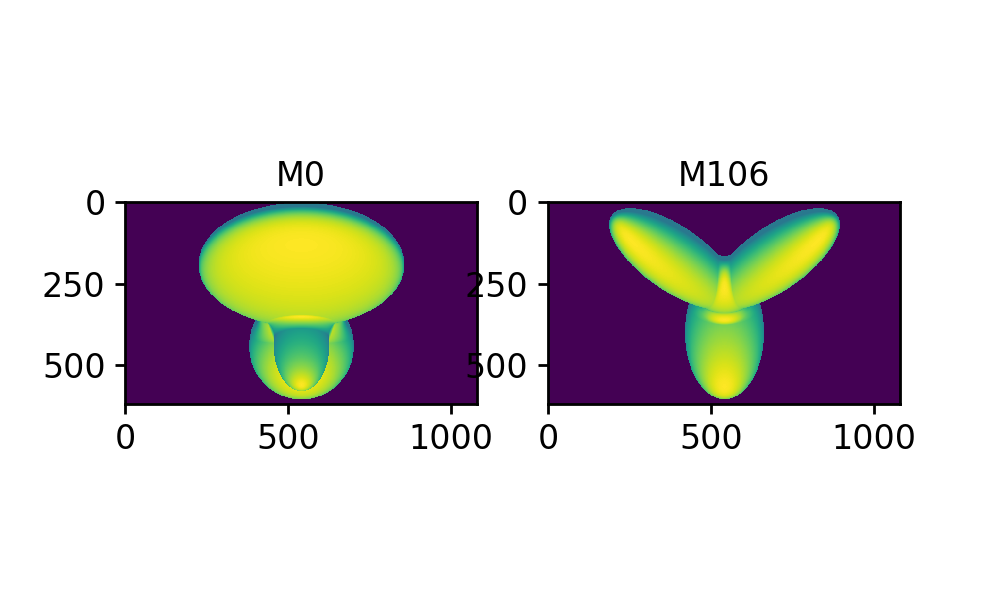

In [83]:
images = load_stimuli(root='/n/home00/juliana.rhee')
print("im shape:", images['D1'].shape)
f, axn = pl.subplots(1,2, figsize=(5,3))
axn[0].imshow(images['D1']); axn[0].set_title('M0');
axn[1].imshow(images['D2']); axn[1].set_title('M106');


## Project stimuli into screenspace

In [68]:
screen_width_deg = screeninfo['azimuth_deg'] #59.7782*2.  #S.screen['linmaxW']*2
screen_height_deg = screeninfo['altitude_deg'] #33.6615*2. #S.screen['linmaxH']*2

pix_per_degW = screeninfo['resolution'][0] / screen_width_deg
pix_per_degH = screeninfo['resolution'][1] / screen_height_deg 

print(pix_per_degW, pix_per_degH)
pix_per_deg = np.mean([pix_per_degW, pix_per_degH])
print("avg pix/deg: %.2f" % pix_per_deg)
print(1/screeninfo['deg_per_pixel'][0])

(16.059366123436302, 16.042065861592622)
avg pix/deg: 16.05
16.0593661234


### Test w 1 image

In [69]:
im = images['D1'].copy()

# Reshape stimulus to what it would be at size_deg
size_deg = 30
im_r = resize_image_to_coords(im, size_deg=size_deg)
print(im_r.shape)

# Get extent of resized image, relative to stimulus coordinates
extent=[-im_r.shape[1]/2. + stim_xpos, im_r.shape[1]/2. + stim_xpos, 
        -im_r.shape[0]/2. + stim_ypos, im_r.shape[0]/2. + stim_ypos]

# Get screen resolution
res = [screeninfo['resolution'][1], screeninfo['resolution'][0]]

# Create array (dims=resolution)
sim_screen = place_stimulus_on_screen(im, extent, resolution=res)

16.05
(30, 52)
[-1.0, 51.0, -20.0, 10.0]
[943, 1779, 219, 701]


### Test RF of 1 cell

In [377]:
rid=0

convert_params = ['x0', 'y0', 'fwhm_x', 'fwhm_y', 'std_x', 'std_y']
x0_deg, y0_deg, fwhm_x_deg, fwhm_y_deg, std_x_deg, std_y_deg =  curr_rfs.loc[rid][convert_params].values

ell_params = convert_fitparams_to_pixels(rid, curr_rfs, pix_per_deg=pix_per_deg)
x0, y0, sz_x, sz_y, theta = ell_params

mask = np.zeros_like(sim_screen.astype(np.uint8))
rows, cols = mask.shape
# create a white filled ellipse
mask=cv2.ellipse(mask, (int(x0), int(y0)), (int(sz_x), int(sz_y)), 
                 np.rad2deg(theta), 
                 startAngle=360, endAngle=0, color=1, thickness=-1)

# Bitwise AND operation to black out regions outside the mask
#result = np.bitwise_and(sim_screen.astype(int), mask)
result = sim_screen * mask


<IPython.core.display.Javascript object>


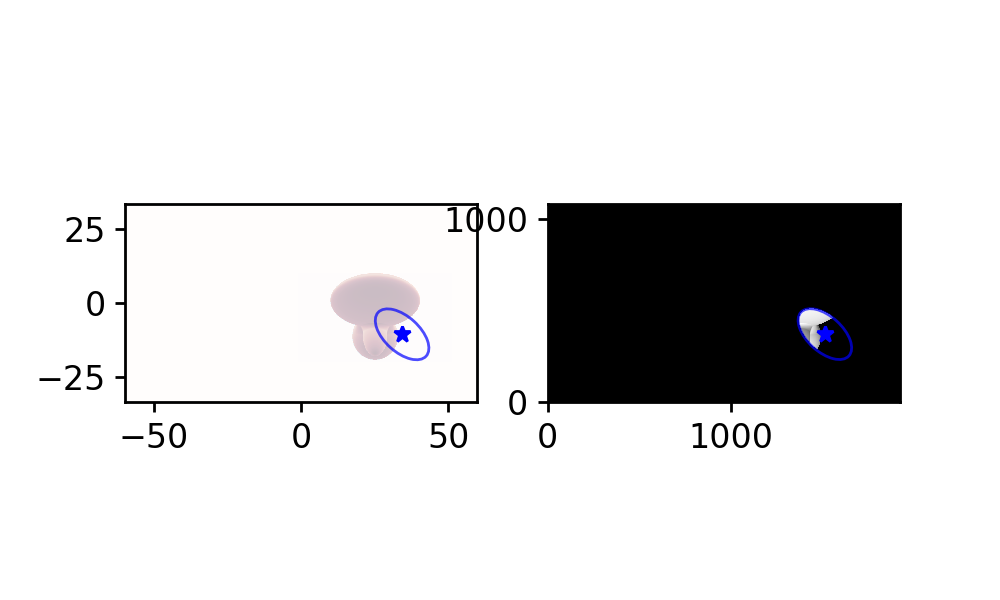

In [84]:
fig, axn = pl.subplots(1, 2, figsize=(5,3))
#theta = 0
ax=axn[0]
ax.set_xlim([screenleft, screenright])
ax.set_ylim([screenbottom, screentop])

# Plot stimulus on screen
im0 = ax.imshow(sim_screen, alpha=0.2, cmap='Reds', 
                extent=[screenleft, screenright, screentop, screenbottom])

# Overlay original image (plotted w/ extent) to double-check
im0 = ax.imshow(im, extent=extent, alpha=0.1, cmap='Blues')

# Plot original RF of cell
ax.plot(x0_deg, y0_deg, 'b*')
ell = Ellipse((x0_deg, y0_deg), fwhm_x_deg, fwhm_y_deg, angle=np.rad2deg(theta))
ell.set_alpha(0.7)
ell.set_edgecolor('b')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 

# Plot masked stimulus in screen/pixel coords
ax = axn[1]
ax.imshow(result, cmap='gray')

# Plot RF on this image, too
ax.plot(x0, y0, 'b*')
ell = Ellipse((x0, y0), sz_x*2., sz_y*2., angle=np.rad2deg(theta))
ell.set_alpha(0.7)
ell.set_edgecolor('b')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 
ax.invert_yaxis()

# FFT

In [ ]:
import numpy as np
import numpy.fft as fft
from scipy import signal
from scipy import fftpack

In [181]:
def get_bbox_around_nans(rpatch, replace_nans=True, return_indices=False):
    bb_xmax, bb_ymax = np.max(np.where(~np.isnan(rpatch)), 1)
    bb_xmin, bb_ymin = np.min(np.where(~np.isnan(rpatch)), 1)
    # print(bb_xmax, bb_ymax)

    tp = rpatch[bb_xmin:bb_xmax, bb_ymin:bb_ymax]
    bb_patch=tp.copy()
    if replace_nans:
        bb_patch[np.where(np.isnan(tp))] = -1
        
    if return_indices:
        return bb_xmin, bb_xmax, bb_ymin, bb_ymax
    else:
        return bb_patch


In [136]:
def blur_mask(mask, ks=None):
    mask_p = mask.astype(float)
    if ks is None:
        ks = int(min(mask_p.shape)/2.)+1
    mask_win = cv2.GaussianBlur(mask_p, (ks, ks), 0)
    return mask_win

In [259]:
def colorbar(mappable, label=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    if label is not None:
        cax.set_title(label)
    return cbar

In [260]:
def get_fft_magnitude(img):
    '''
    https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
    '''
    M, N = img.shape
    F = fftpack.fftn(img)
    F_magnitude = np.abs(F)
    F_magnitude = fftpack.fftshift(F_magnitude)
    
    return F_magnitude, M, N

def plot_psd_2d(F_magnitude, M, N, cmap='viridis', ax=None):
    if ax is None:
        f, ax = pl.subplots()

    im=ax.imshow(np.log(1 + F_magnitude), cmap=cmap,
              extent=(-N // 2, N // 2, -M // 2, M // 2))
    # ax.set_title('Spectrum magnitude');
    ax.set_aspect('equal')
    colorbar(im)
    return ax

In [271]:
def makeSpectrum(E, dx=None, dy=None, upsample=10):
    """
    https://stackoverflow.com/questions/45496634/two-dimensional-fft-showing-unexpected-frequencies-above-nyquisit-limit
    
    Convert a time-domain array `E` to the frequency domain via 2D FFT. `dx` and
    `dy` are sample spacing in x (left-right, 1st axis) and y (up-down, 0th
    axis) directions. An optional `upsample > 1` will zero-pad `E` to obtain an
    upsampled spectrum.

    Returns `(spectrum, xf, yf)` where `spectrum` contains the 2D FFT of `E`. If
    `Ny, Nx = spectrum.shape`, `xf` and `yf` will be vectors of length `Nx` and
    `Ny` respectively, containing the frequencies corresponding to each pixel of
    `spectrum`.

    The returned spectrum is zero-centered (via `fftshift`). The 2D FFT, and
    this function, assume your input `E` has its origin at the top-left of the
    array. If this is not the case, i.e., your input `E`'s origin is translated
    away from the first pixel, the returned `spectrum`'s phase will *not* match
    what you expect, since a translation in the time domain is a modulation of
    the frequency domain. (If you don't care about the spectrum's phase, i.e.,
    only magnitude, then you can ignore all these origin issues.)
    """
    dx = E.shape[0] if dx is None else dx
    dy = E.shape[1] if dy is None else dy
    
    zeropadded = np.array(E.shape) * upsample
    F = fft.fftshift(fft.fft2(E, zeropadded)) / E.size
    xf = fft.fftshift(fft.fftfreq(zeropadded[1], d=dx))
    yf = fft.fftshift(fft.fftfreq(zeropadded[0], d=dy))
    return (F, xf, yf)

def extents(f):
    "Convert a vector into the 2-element extents vector imshow needs"
    delta = f[1] - f[0]
    return [f[0] - delta / 2, f[-1] + delta / 2]

def plotSpectrum(F, xf, yf, logplot=True, ax=None, label_axes=True, cmap='gray'):
    "Plot a spectrum array and vectors of x and y frequency spacings"
    mag = np.abs(F)
    if logplot:
        psd = 10*np.log10(mag**2)
        label = 'dB'
    else:
        psd = mag.copy()
        label = 'magnitude'
    if ax is None:
        f, ax = pl.subplots() #pl.figure()
    im = ax.imshow(psd,
               aspect="equal",
               interpolation="none",
               origin="lower",
               extent=extents(xf) + extents(yf), 
               cmap=cmap)
    colorbar(im, label=label)
    if label_axes:
        ax.set_xlabel('f_x (Hz)')
        ax.set_ylabel('f_y (Hz)')
        ax.set_title('Power Spectrum')
    #pl.show()
    return ax


# # Sinusoid frequency, in Hz
# x0 = 1.9
# y0 = -2.9

# # Generate data
# im = np.exp(2j * np.pi * (y[:, np.newaxis] * y0 + x[np.newaxis, :] * x0))

# Generate spectrum and plot
# spectrum, xf, yf = makeSpectrum(result, res[1], res[0], upsample=1) #x[1] - x[0], y[1] - y[0])
# plotSpectrum(spectrum, xf, yf)

# # Report peak
# #peak = spectrum[:, np.isclose(xf, x0)][np.isclose(yf, y0)]
# #peak = peak[0, 0]
# #print('spectral peak={}'.format(peak))

# Units?

In [215]:
screeninfo

{'altitude_cm': 58,
 'altitude_deg': 67.323,
 'azimuth_cm': 103,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

In [221]:
height_pix = res[0] 
height_cm = screeninfo['altitude_cm'] 
distance= 30. 

dX = height_cm/height_pix # cm/pix, pitch (delta X, 1/dX is dpi)

per = 2*dX
arc_theta = np.rad2deg(2*np.arctan(per/(2*distance))) # degrees
retina_sf = 1./arc_theta # cycles per deg
print("Retinal arc theta: %.2f deg\nspatial freq: %.2f c.p.d." 
          % (arc_theta, retina_sf))


Retinal arc theta: 0.21 deg
spatial freq: 4.87 c.p.d.


# Stimulate with known SF/Ori

In [673]:
def genSinusoid(sz, A, omega, rho):
    # Generate Sinusoid grating
    # sz: size of generated image (width, height)
    # rho=phase, omega=frequency
    radius = (int(sz[1]/2.0), int(sz[0]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1)) 
    # a BUG is fixed in this line

    stimuli = A * np.cos(omega[0] * x  + omega[1] * y + rho)
    return stimuli

def get_sinusoid(res, n_cycles=4):

    M, N = res

    #N = 1920 #1080
    #M = 1080 #1920

    x = np.arange(0, N)
    y = np.arange(0, M)

    X,Y = np.meshgrid(x,y) ; 
    im = (1./2)*( 1+np.sin(2*np.pi/N*n_cycles*X) )

    return im

In [720]:
def generate_sinusoid(sf=0.2, pix_per_deg=16.05, res=[1080, 1920]):

    #n_cycles_per_deg = 1.2 # sf
    n_cycles_per_pix = sf / float(pix_per_deg)
    n_cycles = n_cycles_per_pix * res[1]
    print(n_cycles)
    
    print('Specified %.2f cyc/deg.\n @ %.2f pix/deg, this is %.1f cycles (%.2f cyc/pix)' 
          % (sf, pix_per_deg, n_cycles, n_cycles_per_pix))
    
    
    sin_im = get_sinusoid(res, n_cycles=n_cycles)

    return sin_im


# 4 cycles per screen
# 4cyc/1920 pixels = 

# res_dims = (10,40)
# n_cycles = 3
# n_cycles_per_pix = n_cycles/float(res_dims[1])
# n_cycles_per_deg = n_cycles_per_pix * pix_per_deg

# print('%.1f cycles (%.2f cyc/pix)\nThis is %.2f cyc/deg (%.2f pix/deg)' 
#           % (n_cycles, n_cycles_per_pix, n_cycles_per_deg, pix_per_deg))

# im_test = get_sinusoid(res_dims, n_cycles=n_cycles)

# pl.figure()
# pl.imshow(im_test)


(232, 508, 1364, 1656)
(276, 292)
1.81931464174
Specified 0.10 cyc/deg.
 @ 16.05 pix/deg, this is 1.8 cycles (0.01 cyc/pix)
11.9626168224
Specified 0.10 cyc/deg.
 @ 16.05 pix/deg, this is 12.0 cycles (0.01 cyc/pix)


<IPython.core.display.Javascript object>


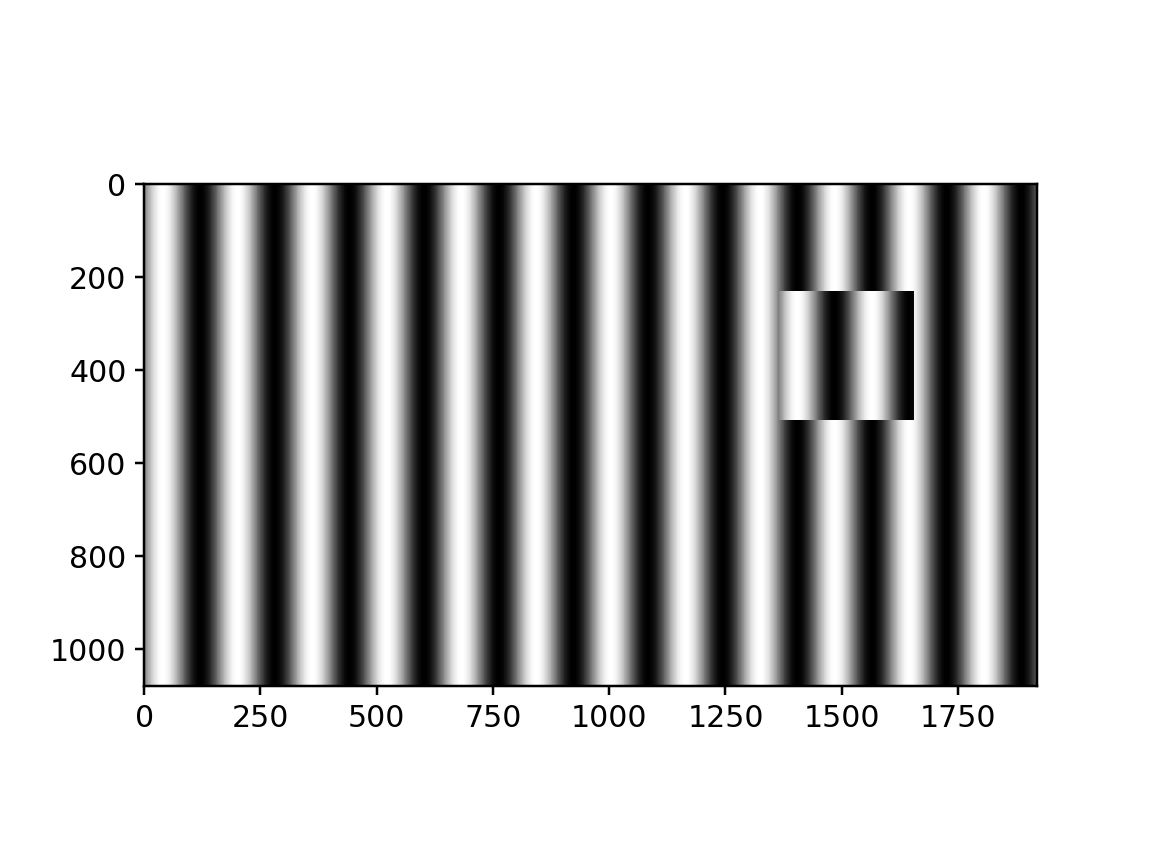

In [837]:
mask_nan = mask.copy().astype(float)
mask_nan[mask==0]=np.nan

bb_xmin, bb_xmax, bb_ymin, bb_ymax = get_bbox_around_nans(mask_nan, replace_nans=True, return_indices=True)
print(bb_xmin, bb_xmax, bb_ymin, bb_ymax )

mask_bb = mask_nan[bb_xmin:bb_xmax, bb_ymin:bb_ymax]
print(mask_bb.shape)



win_M, win_N = mask_bb.shape

sf_value=0.1
#im_patch = get_sinusoid((win_M, win_N), n_cycles=4)
im_patch = generate_sinusoid(sf=sf_value, pix_per_deg=16.05, res=(win_M, win_N))
    
im_screen = generate_sinusoid(sf=0.1, pix_per_deg=16.05, res=res)
im_screen[bb_xmin:bb_xmax, bb_ymin:bb_ymax] = im_patch

pl.figure()
pl.imshow(im_screen)



<IPython.core.display.Javascript object>


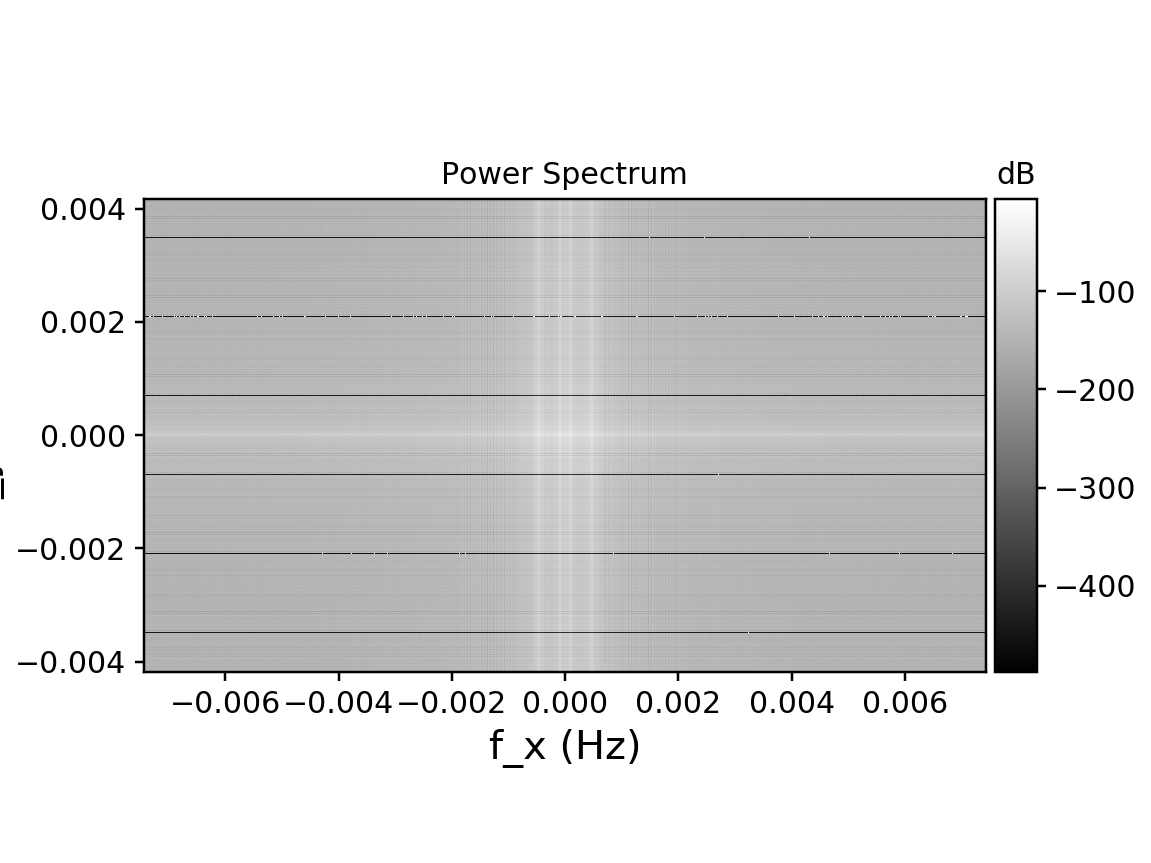

In [798]:
# Generate spectrum and plot
spectrum, xf, yf = makeSpectrum(im_screen, upsample=1) #x[1] - x[0], y[1] - y[0])
f = plotSpectrum(spectrum, xf*pix_per_deg, yf*pix_per_deg, logplot=True, ax=None)


In [685]:
xf.min(), xf.max()

(-0.0018115942028985505, 0.0017991860234266427)

# Plot 2d PSD

<IPython.core.display.Javascript object>


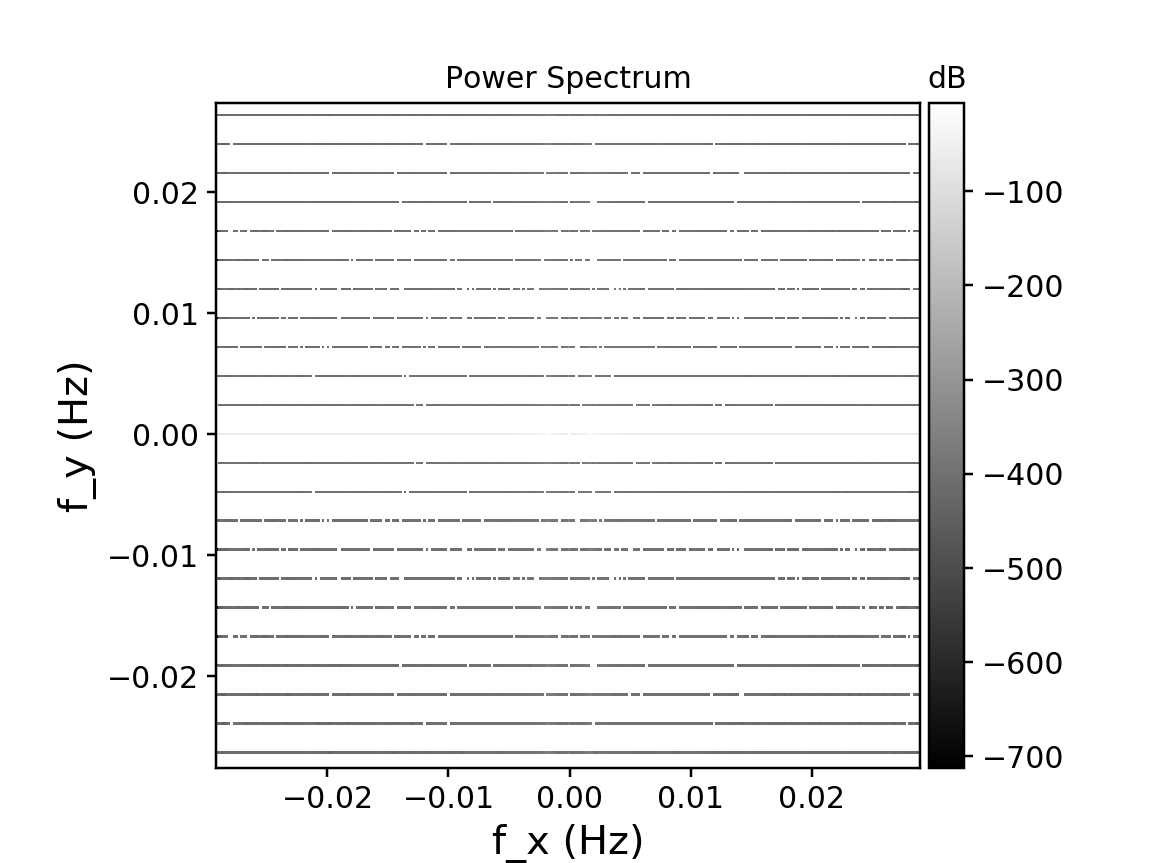

(0.028878223879722515, 0.027284942562220582)


In [746]:
# Generate spectrum and plot
spectrum, xf, yf = makeSpectrum(im_patch, upsample=1) #x[1] - x[0], y[1] - y[0])
f = plotSpectrum(spectrum, xf*pix_per_deg, yf*pix_per_deg, logplot=True, ax=None)
print((xf*pix_per_deg).max(), (yf*pix_per_deg).max())

<IPython.core.display.Javascript object>


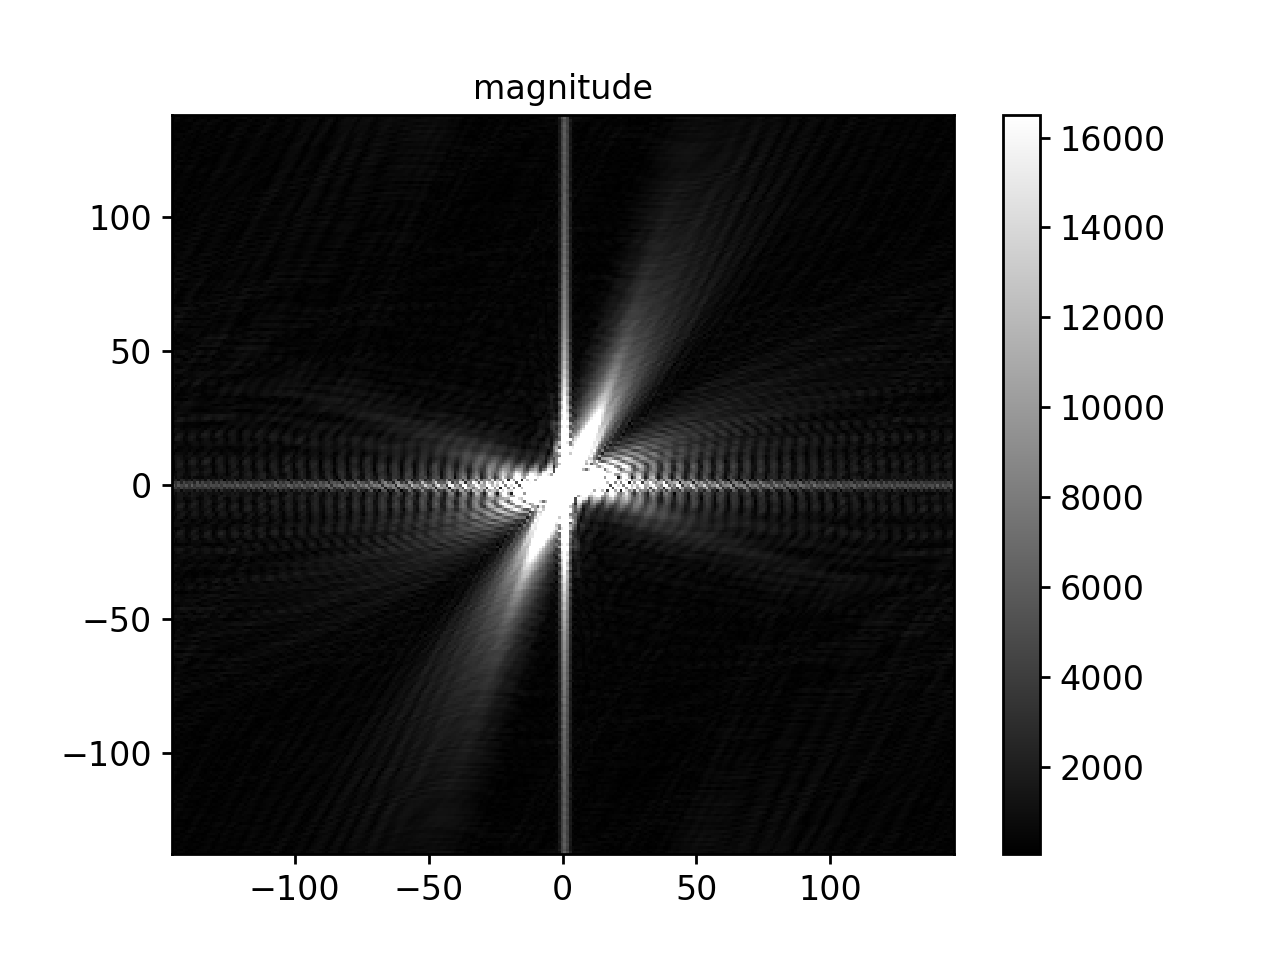

In [228]:
M, N = win_patch.shape
y    = np.fft.fft2(win_patch)

clim = np.quantile(np.abs(y.reshape(-1)), [.01, .99])
mag = np.fft.fftshift(np.abs(y)) # Shift so results are centered around 0

pl.figure()
pl.imshow(mag, vmin=clim[0], vmax=clim[1], 
          extent=(-N // 2, N // 2, -M // 2, M // 2))
#pl.gray()
pl.title('magnitude')
pl.show()
pl.colorbar()

#### Compare full and patch spectra

In [689]:

# fft on full result
full_F_magnitude, full_M, full_N = get_fft_magnitude(np.flipud(result))

# fft on patch bbox only
patch_F_magnitude, patch_M, patch_N = get_fft_magnitude(np.flipud(bb_patch))


# Blur, extract on patch only
ks=101
win_mask = blur_mask(mask.astype(float), ks=ks)
w_patch = win_mask*sim_screen
win_patch = w_patch[bb_xmin:bb_xmax, bb_ymin:bb_ymax]
win_F_magnitude, win_M, win_N = get_fft_magnitude(np.flipud(win_patch))


<IPython.core.display.Javascript object>


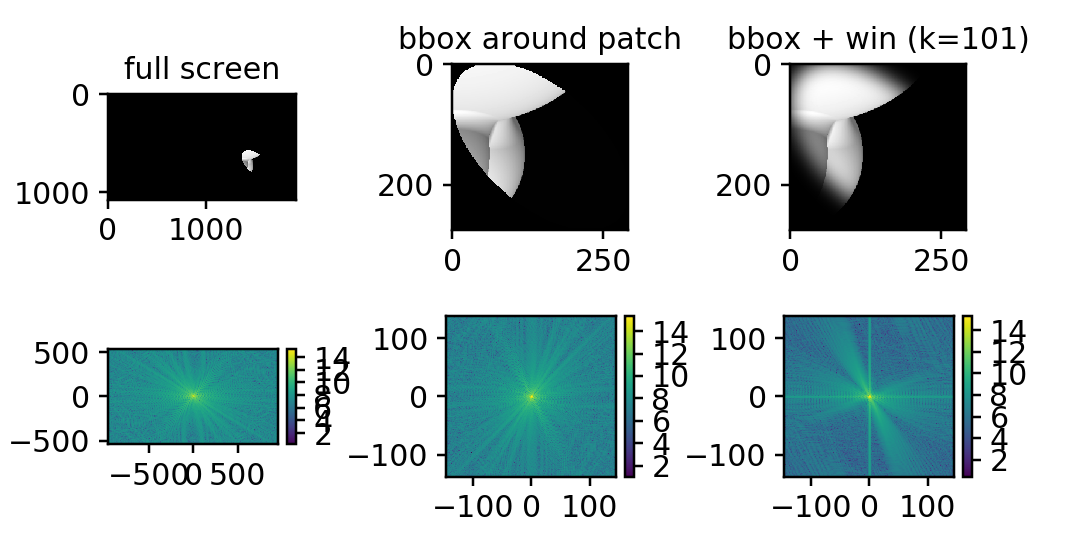

In [690]:
f, axn = pl.subplots(2, 3, figsize=(6, 3))

# Full
ax=axn[0, 0]; ax.imshow(np.flipud(result)); ax.set_title('full screen'); 
ax=axn[1, 0]
ax = plot_psd_2d(F_magnitude, M, N, ax=ax)

# BBox
ax=axn[0, 1]; 
ax.imshow(np.flipud(bb_patch)); ax.set_title('bbox around patch');
ax=axn[1, 1]
ax = plot_psd_2d(patch_F_magnitude, patch_M, patch_N, ax=ax)


ax=axn[0, 2]; ax.imshow(np.flipud(win_patch)); ax.set_title('bbox + win (k=%i)' % ks);
ax=axn[1, 2]
ax = plot_psd_2d(win_F_magnitude, win_M, win_N, ax=ax)

pl.subplots_adjust(left=0.1, wspace=0.8, hspace=0.5)

<IPython.core.display.Javascript object>


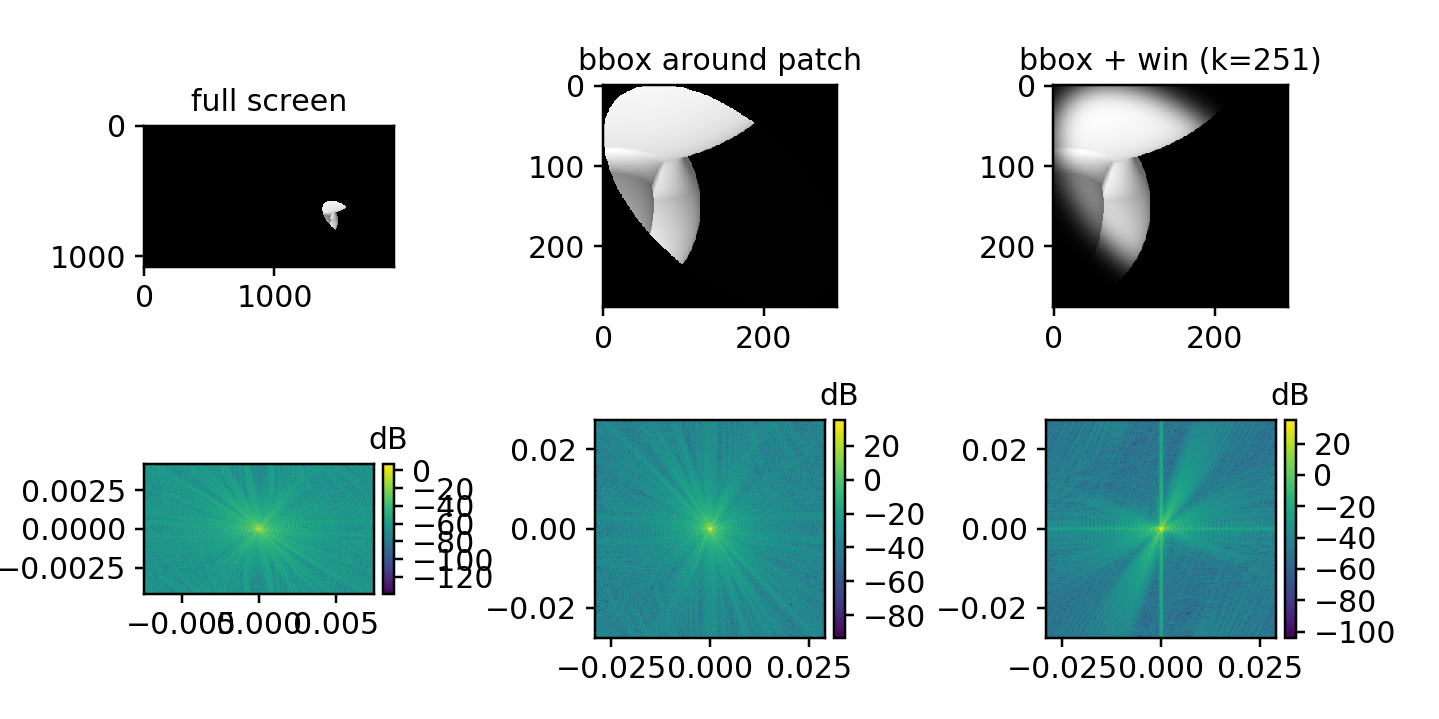

In [493]:
cmap='viridis'
ks=251

f, axn = pl.subplots(2, 3, figsize=(8, 4))

# Full
ax=axn[0, 0]; ax.imshow(np.flipud(result)); ax.set_title('full screen'); 
ax=axn[1, 0]
full_spectrum, full_xf, full_yf = makeSpectrum(np.flipud(result), upsample=1) #x[1] - x[0], y[1] - y[0])
ax = plotSpectrum(full_spectrum, full_xf*pix_per_deg, full_yf*pix_per_deg, 
                  logplot=True, ax=ax, label_axes=False, cmap=cmap)

# BBox
ax=axn[0, 1]; 
ax.imshow(np.flipud(bb_patch)); ax.set_title('bbox around patch');
ax=axn[1, 1]
bb_spectrum, bb_xf, bb_yf = makeSpectrum(np.flipud(bb_patch), upsample=1) #x[1] - x[0], y[1] - y[0])
ax = plotSpectrum(bb_spectrum, bb_xf*pix_per_deg, bb_yf*pix_per_deg,
                  logplot=True, ax=ax, label_axes=False, cmap=cmap)


ax=axn[0, 2]; ax.imshow(np.flipud(win_patch)); ax.set_title('bbox + win (k=%i)' % ks);
ax=axn[1, 2]
win_spectrum, win_xf, win_yf = makeSpectrum(np.flipud(win_patch), upsample=1) #x[1] - x[0], y[1] - y[0])
ax = plotSpectrum(win_spectrum, win_xf*pix_per_deg, win_yf*pix_per_deg,
                  logplot=True, ax=ax, label_axes=False, cmap=cmap)

pl.subplots_adjust(left=0.1, wspace=0.8, hspace=0.5)

In [285]:
# from skimage import img_as_float
# from skimage.color import rgb2gray
# from skimage.data import astronaut
# from scipy import signal

In [314]:
psd2D.shape

(276, 292)

In [320]:
fx=np.arange(0,3)
fy = np.arange(0,5)
xx, yy = np.meshgrid(fx, fy)
xx

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [844]:
from scipy import ndimage
from pipeline.python.classifications import radial_data as radial

#===================================================================
# Get PSD 1D (total radial power spectrum)
#===================================================================
def get_psd_1D(psd2D, img=None, average=False, cyc_per_deg=False, pix_per_deg=16.05):
    h  = psd2D.shape[0] # smaller, y-axis
    w  = psd2D.shape[1] # x-axis (bigger)
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)
    
    if cyc_per_deg:
        assert img is not None, "Provide original img"
        xf, yf = get_freqs(img, cyc_per_deg=False, pix_per_deg=pix_per_deg)
        
        f_wc = xf[-(len(xf)/2):] # only need 2nd half # goes with columns
        f_hc = yf[-(len(yf)/2):] # only need 2nd half # goes with rows (height)
        print(len(fx), len(fy))
        assert fx[0]==0, "Bad indexing, x"
        assert fy[0]==0, "Bad indexing, y"
        Y, X = np.meshgrid(xf, yf)
        r_freq    = np.hypot(X, Y) #.astype(np.int)
        # r_freq = r_freq*pix_per_deg
        
    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    if average:
        psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))
    else:
        psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))

    if cyc_per_deg:
        return psd1D, r, r_freq
    else:
        return psd1D, r


#=============================================================================
# Get PSD 1D (total power spectrum by angular bin)
#=============================================================================
def get_binned_psd_1d(psd2D, dTheta, rMin, rMax):
    '''
    https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59
    
    dTheta - widths of angle bins (sectors centered on angles from 0 to 360-dTheta)
    rMin, rMax - exclude values outside of this range (label as -100)
    
    Sum/average over positively-labeled angle regions
    Normalize to total power in all sectors
    '''
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2
    
    # note that displaying PSD as image inverts Y axis
    # create an array of integer angular slices of dTheta
    Y, X  = np.ogrid[0:h, 0:w]
    theta = np.rad2deg(np.arctan2(-(Y-hc), (X-wc)))
    theta = np.mod(theta + dTheta/2 + 360, 360)
    theta = dTheta * (theta//dTheta)
    theta = theta.astype(np.int)
    
    # mask below rMin and above rMax by setting to -100
    R     = np.hypot(-(Y-hc), (X-wc))
    mask  = np.logical_and(R > rMin, R < rMax)
    theta = theta + 100
    theta = np.multiply(mask, theta)
    theta = theta - 100
    
    # SUM all psd2D pixels with label 'theta' for 0<=theta❤60 between rMin and rMax
    angF  = np.arange(0, 360, int(dTheta))
    psd1D = ndimage.sum(psd2D, theta, index=angF)
    
    # normalize each sector to the total sector power
    pwrTotal = np.sum(psd1D)
    psd1D    = psd1D/pwrTotal
    
    return angF, psd1D

#===================================================================


def get_freqs(E, cyc_per_deg=False, pix_per_deg=16.05, upsample=1):
    dx = E.shape[0] 
    dy = E.shape[1] 
    
    zeropadded = np.array(E.shape) * upsample
    #F = fft.fftshift(fft.fft2(E, zeropadded)) / E.size
    xf = fft.fftshift(fft.fftfreq(zeropadded[1], d=dx))
    yf = fft.fftshift(fft.fftfreq(zeropadded[0], d=dy))
    
    if cyc_per_deg:
        return xf*pix_per_deg, yf*pix_per_deg
    else:
        return xf, yf

array([276, 292])

psd2D : in cyc/pixels (since fft over pixel image)
r : radii values thus correspond to different values of cyc/pix 
To convert, need mapping from cyc/pix --> cyc/deg

In [800]:
ks=201
use_full=False

if use_full:
    mask_win = blur_mask(mask, ks=ks)
    win_result = mask_win*sim_screen
else:
    win_mask = blur_mask(mask.astype(float), ks=ks)
    w_patch = win_mask*sim_screen
    win_patch = w_patch[bb_xmin:bb_xmax, bb_ymin:bb_ymax]

# Do w/ gratings1

In [833]:
mask_bb.shape

(276, 292)

(232, 508, 1364, 1656)
(276, 292)
1.81931464174
Specified 0.10 cyc/deg.
 @ 16.05 pix/deg, this is 1.8 cycles (0.01 cyc/pix)
11.9626168224
Specified 0.10 cyc/deg.
 @ 16.05 pix/deg, this is 12.0 cycles (0.01 cyc/pix)


<IPython.core.display.Javascript object>


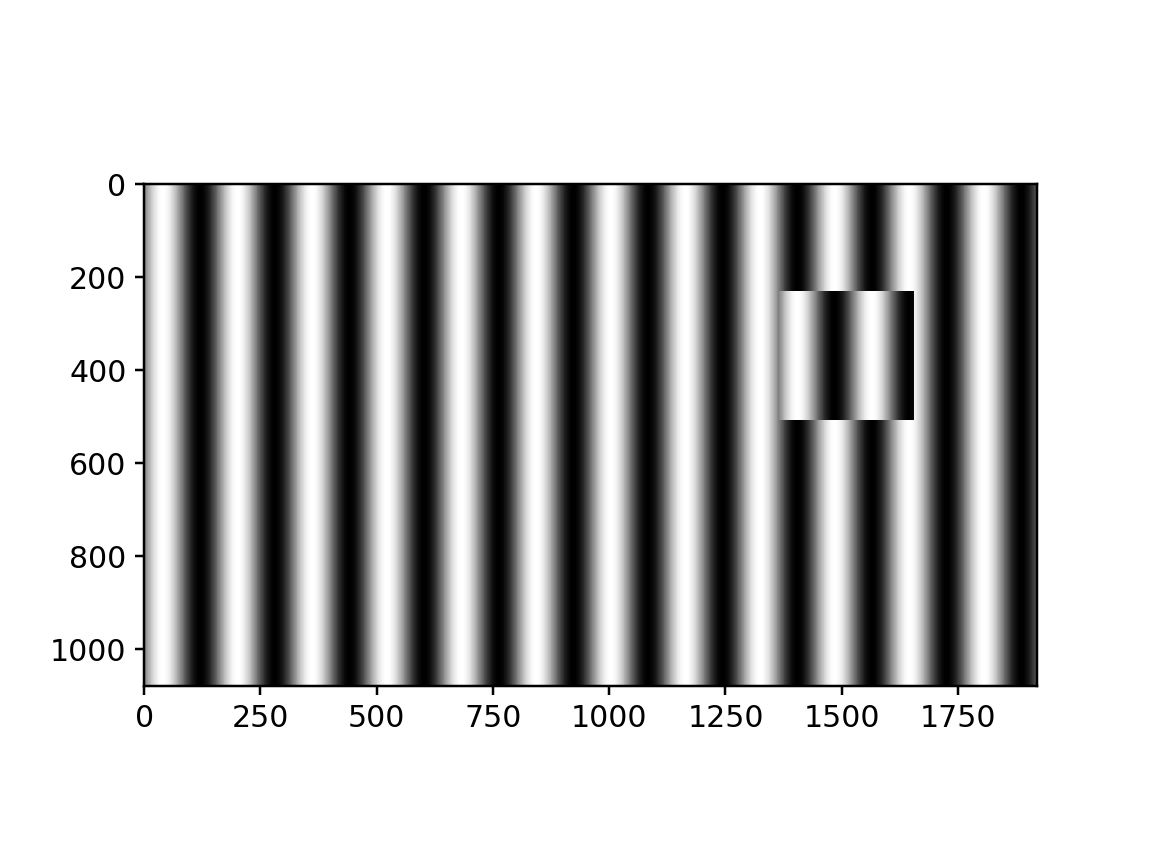

In [838]:
mask_nan = mask.copy().astype(float)
mask_nan[mask==0]=np.nan

bb_xmin, bb_xmax, bb_ymin, bb_ymax = get_bbox_around_nans(
    mask_nan, replace_nans=True, return_indices=True)
print(bb_xmin, bb_xmax, bb_ymin, bb_ymax )

mask_bb = mask_nan[bb_xmin:bb_xmax, bb_ymin:bb_ymax]
print(mask_bb.shape)


win_M, win_N = mask_bb.shape

sf_value=0.1
#im_patch = get_sinusoid((win_M, win_N), n_cycles=4)
im_patch = generate_sinusoid(sf=sf_value, pix_per_deg=16.05, res=[win_M, win_N])
    
im_screen = generate_sinusoid(sf=sf_value, pix_per_deg=16.05, res=res)
im_screen[bb_xmin:bb_xmax, bb_ymin:bb_ymax] = im_patch

pl.figure()
pl.imshow(im_screen)



In [852]:
pix_per_deg

16.050715992514462

In [850]:
img = np.flipud(im_patch)

xf, yf = get_freqs(img, cyc_per_deg=False, pix_per_deg=pix_per_deg)

Y, X = np.meshgrid(xf, yf)
r_freq    = np.hypot(X, Y) #.astype(np.int)
# r_freq = r_freq*pix_per_deg
print(xf.max(), yf.max(), r_freq.max())

(0.0017991860234266427, 0.0016999205876513798, 0.002492778241780362)


In [855]:
M, N = psd2D.shape
u=150.
v=150.

(M/2 - u) / M, (N/2 - v) / N


(-0.043478260869565216, -0.0136986301369863)

In [851]:
xf.max()#(pix_per_deg)

0.4965753424657534

In [848]:
yf.max()*(pix_per_deg)

0.027284942562220582

In [820]:
yf.max() * img.shape[1]

0.4963768115942029

In [803]:
map_type = 'mag'
#img = np.flipud(win_result)
img = np.flipud(im_patch)

# Get 2d PSD
win_spectrum, win_xf, win_yf = makeSpectrum(img, upsample=1) #x[1] - x[0], y[1] - y[0])

if map_type=='mag':
    psd2D = np.abs(win_spectrum)
elif map_type=='power':
    psd2D = np.abs(win_spectrum)**2
else:
    pwr = np.abs(win_spectrum)**2
    psd2D = 10*np.log10(pwr)


# Get 1d PSD
psd_1d, r, r_freq = get_psd_1D(psd2D, img=img, average=True, cyc_per_deg=True)
print(r_freq.min(), r_freq.max())


# Get freqs
xf, yf = get_freqs(img, cyc_per_deg=True, pix_per_deg=pix_per_deg)
frequencies = xf[-len(psd_1d):] # only need 2nd half
# print(yf.max(), xf.max())
print((xf*pix_per_deg).max(), (yf*pix_per_deg).max())

# Get radii extzens
r_extent = (-r.shape[1]/2, r.shape[1]/2, -r.shape[0]/2, r.shape[0]/2)
print(r_extent, r.shape)

(3, 5)
(0.0, 0.04000909078057481)
(0.4635161698616752, 0.4379428639382724)
((-146, 146, -138, 138), (276, 292))


<IPython.core.display.Javascript object>


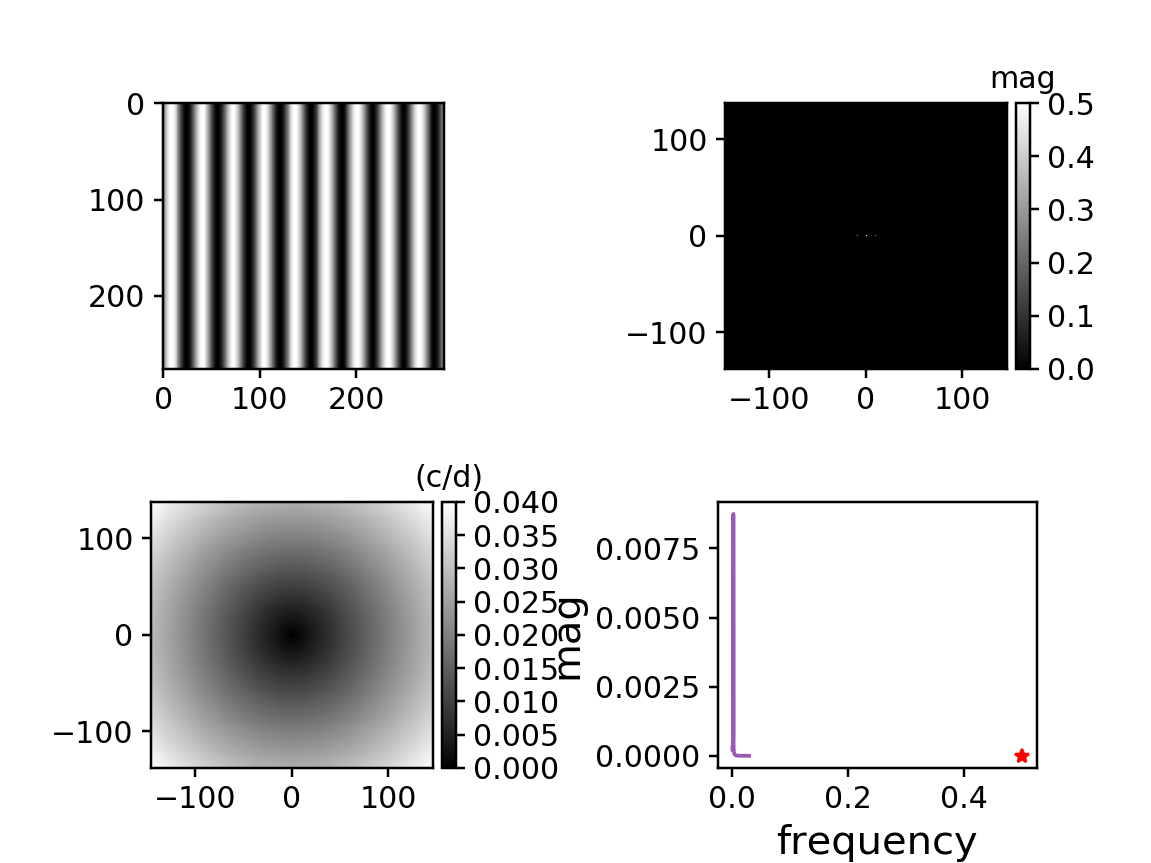

In [804]:
f, axf = pl.subplots(2, 2)
axn = axf.flat

axn[0].imshow(img);

im = axn[1].imshow(psd2D, extent=r_extent)
colorbar(im, label=map_type)

im = axn[2].imshow(r_freq, extent=r_extent)
colorbar(im, label='(c/d)')

#radii_bins, az_avg = radial.azimuthalAverage(psd2D, returnradii=True, binsize=0.5)

axn[3].plot(frequencies[1:], psd_1d[1:])
axn[3].plot(sf_value, 0, 'r*')

axn[3].set_xlabel('frequency')
axn[3].set_ylabel(map_type)


pl.subplots_adjust(hspace=0.5, wspace=0.8)


In [518]:
len(radii_bins), len(xf)

(201, 292)

<IPython.core.display.Javascript object>


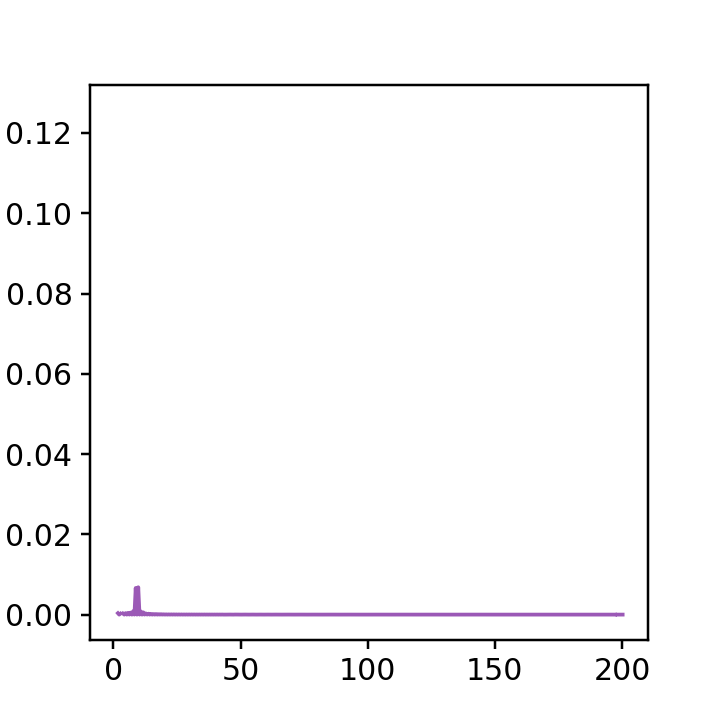

In [807]:
radii_bins, az_avg = radial.azimuthalAverage(psd2D, returnradii=True, binsize=.5)
pl.figure(figsize=(4,4))
pl.plot(radii_bins, az_avg)

In [808]:
radii_bins

array([  0.25,   0.75,   1.25,   1.75,   2.25,   2.75,   3.25,   3.75,
         4.25,   4.75,   5.25,   5.75,   6.25,   6.75,   7.25,   7.75,
         8.25,   8.75,   9.25,   9.75,  10.25,  10.75,  11.25,  11.75,
        12.25,  12.75,  13.25,  13.75,  14.25,  14.75,  15.25,  15.75,
        16.25,  16.75,  17.25,  17.75,  18.25,  18.75,  19.25,  19.75,
        20.25,  20.75,  21.25,  21.75,  22.25,  22.75,  23.25,  23.75,
        24.25,  24.75,  25.25,  25.75,  26.25,  26.75,  27.25,  27.75,
        28.25,  28.75,  29.25,  29.75,  30.25,  30.75,  31.25,  31.75,
        32.25,  32.75,  33.25,  33.75,  34.25,  34.75,  35.25,  35.75,
        36.25,  36.75,  37.25,  37.75,  38.25,  38.75,  39.25,  39.75,
        40.25,  40.75,  41.25,  41.75,  42.25,  42.75,  43.25,  43.75,
        44.25,  44.75,  45.25,  45.75,  46.25,  46.75,  47.25,  47.75,
        48.25,  48.75,  49.25,  49.75,  50.25,  50.75,  51.25,  51.75,
        52.25,  52.75,  53.25,  53.75,  54.25,  54.75,  55.25,  55.75,
      

In [521]:
len(np.unique(r_freq)), len(radii_bins)


(8394, 2003)

In [ ]:
color_list = sns.color_palette(cmap, n_colors=len(rmin_values))


<IPython.core.display.Javascript object>


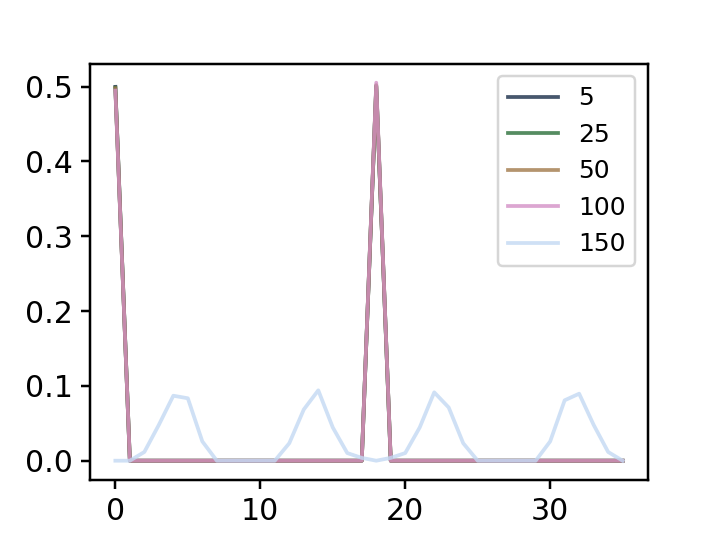

In [806]:
cmap='cubehelix'

dTheta = 10
rMin = 50
rMax = 250
#angF, psd1D_binned = get_binned_psd_1d(psd2D, dTheta, rMin, rMax)
#psd1D_binned.shape, angF.shape, 
rmin_vals = [5, 25, 50, 100, 150]
color_list = sns.color_palette(cmap, n_colors=len(rmin_vals))

fig, ax = pl.subplots(figsize=(4,3))
for rMin, rcol in zip(rmin_vals, color_list):
    angF, psd1D_binned = get_binned_psd_1d(psd2D, dTheta, rMin, rMax)
    ax.plot(psd1D_binned, label=rMin, alpha=0.8, color=rcol)
ax.legend()


<IPython.core.display.Javascript object>


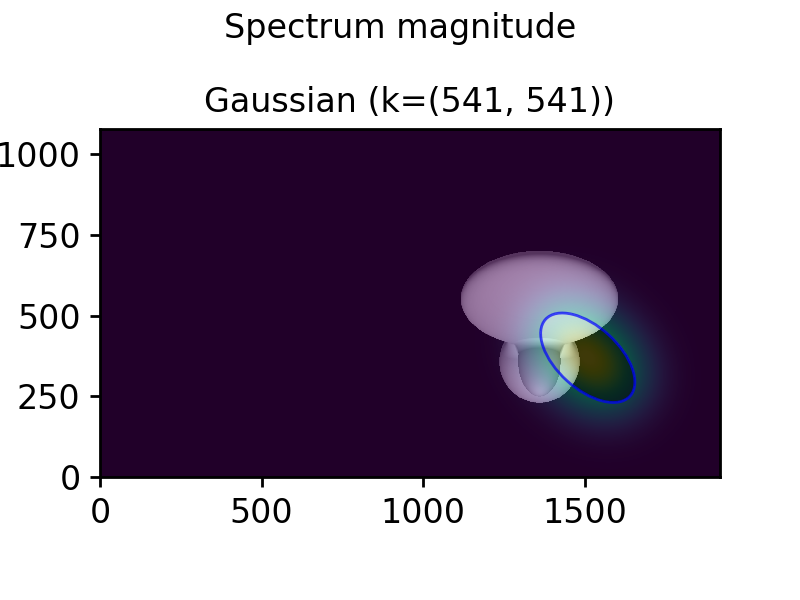

In [125]:
# Blur the mask so we don't have such hard edges
mask_p = mask.copy().astype(float)
ks = int(min(mask_p.shape)/2.)+1
mask_win = cv2.GaussianBlur(mask_p, (ks, ks), 0)

# Get apertured image
rmask = result.copy().astype(float)
rmask[mask==0] = np.nan

fig, ax = pl.subplots(figsize=(4,3)) #pl.figure()

# original stimulus on screeen
ax.imshow(sim_screen, cmap='gray')

# windows RF
ax.imshow(mask_win, alpha=0.5)
ax.set_title('Gaussian (k=(%i, %i))' % (ks, ks))

# part of image visible by RF
ax.imshow(rmask, cmap='gray', alpha=0.5)

# outline of RF
ell = Ellipse((x0, y0), sz_x*2., sz_y*2., angle=np.rad2deg(theta))
ell.set_alpha(0.7)
ell.set_edgecolor('b')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 
ax.invert_yaxis()

#### Test a few vals

In [153]:
# ks_values = [int(min(mask_p.shape))+1, int(min(mask_p.shape)/2.)+1, 
#              int(min(mask_p.shape)/4.)+1, int(min(mask_p.shape)/8.)+1]

ks_values = []
for i in [-1, 1, 2, 4, 8, 16, 0]:
    if i in [-1, 0]: 
        ks_values.append(i)
        continue
    kv = int(min(mask.shape)/float(i))
    if kv%2==0: 
        kv += 1
    ks_values.append(kv)
print(ks_values)

[-1, 1081, 541, 271, 135, 67, 0]


<IPython.core.display.Javascript object>


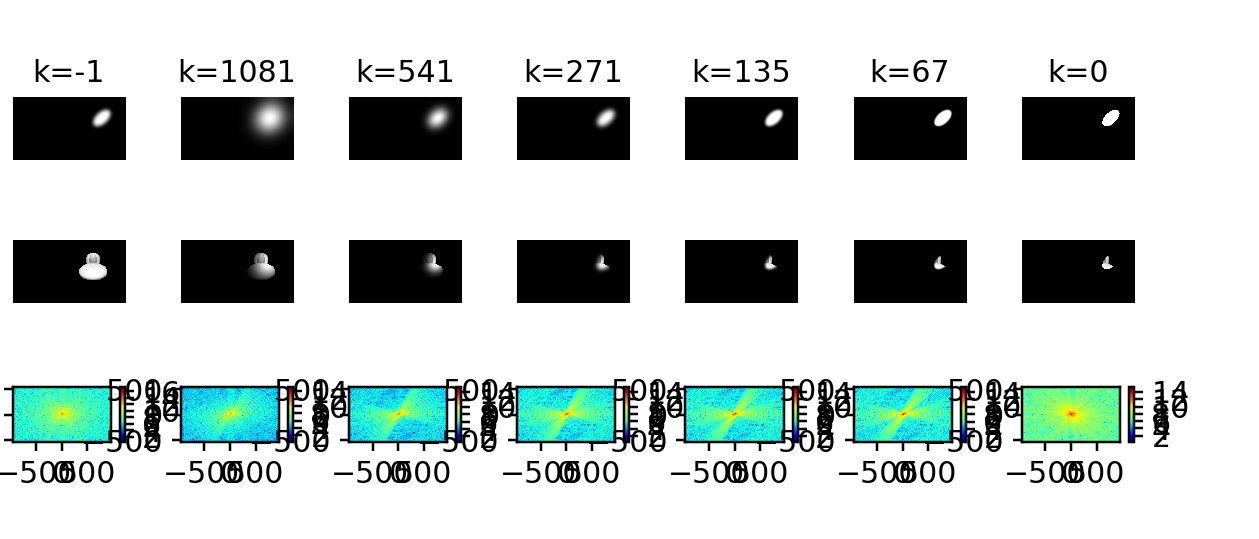

Text(0.5,0.98,u'Spectrum magnitude')

In [399]:
f, axn = pl.subplots(3, len(ks_values), figsize=(len(ks_values)*1,3))
for ki, ks in enumerate(ks_values):
    # Get the mask
    if ks==-1:
        win_result = sim_screen.copy().astype(float) 
    else:
        if ks==0:
            mask_win = mask.copy().astype(float)
        else:
            mask_win = blur_mask(mask, ks=ks)
        win_result = mask_win*sim_screen
    
    # Do the fft
    win_F_magnitude, M, N = get_fft_magnitude(win_result)
    
    # Plot it
    ax=axn[0, ki]
    ax.axis('off')
    ax.imshow(mask_win); ax.set_title('k=%i' % ks);
    ax=axn[1, ki]
    ax.axis('off')
    ax.imshow(win_result)
    ax.axis('off')
    
    ax=axn[2, ki]
    im=ax.imshow(np.log(1 + win_F_magnitude), cmap='jet',
              extent=(-N // 2, N // 2, -M // 2, M // 2))
    ax.set_aspect('equal')
    colorbar(im)

pl.subplots_adjust(left=0.01, right=0.9, wspace=0.5, hspace=0.1)
# for ax in axn.flat:
#     ax.axis('off')

fig.suptitle('Spectrum magnitude')

<IPython.core.display.Javascript object>


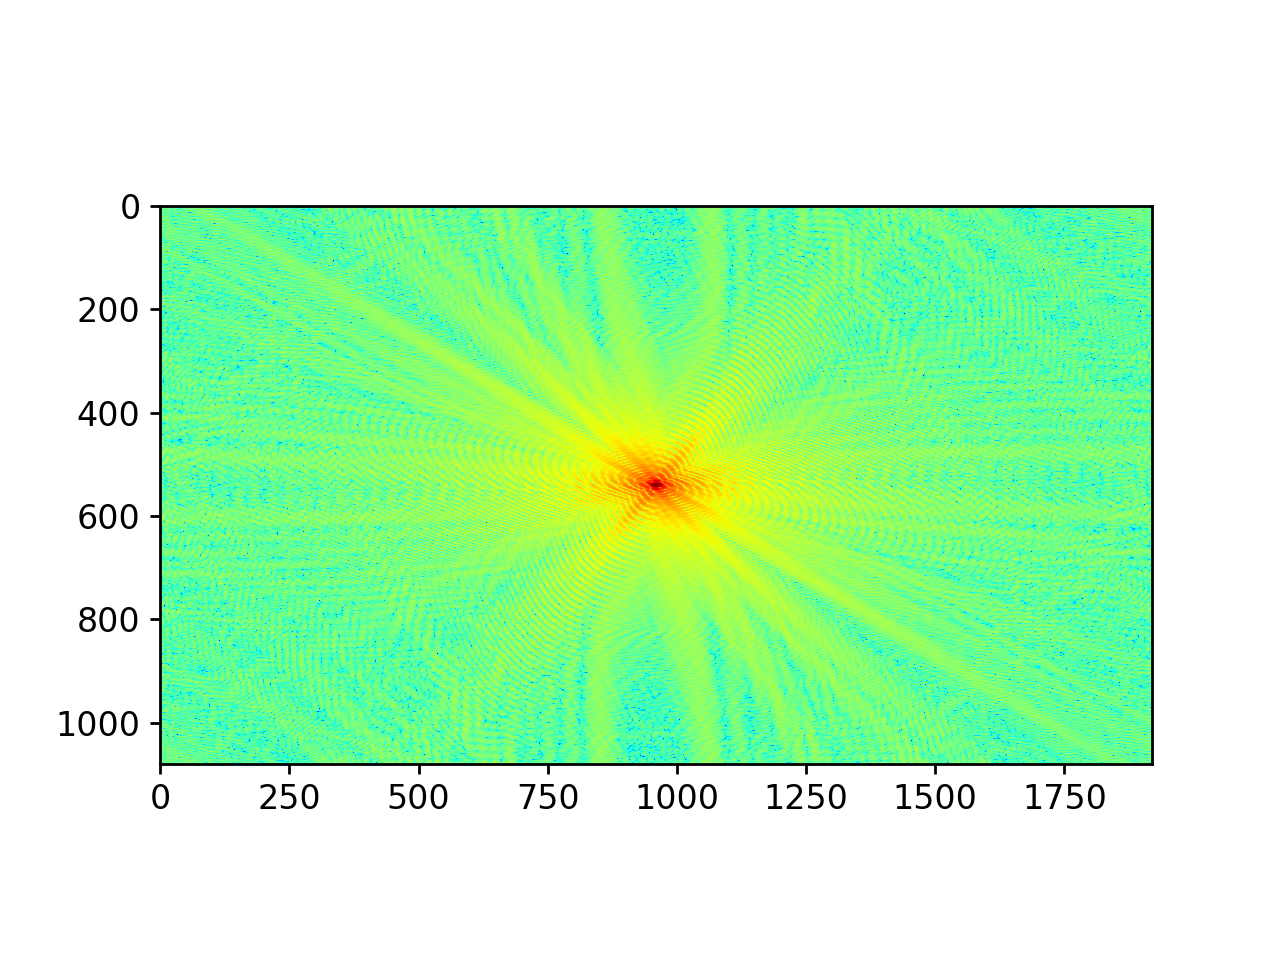

In [161]:
psd_2d = np.log(1 + win_F_magnitude)

pl.figure()
pl.imshow(psd_2d, cmap='jet')

##### plot all steps

In [ ]:
# Select a kernel size
mask_win = blur_mask(mask, ks=ks)
win_result = mask_win*sim_screen

# Do the fft
win_F_magnitude, M, N = get_fft_magnitude(win_result)


<IPython.core.display.Javascript object>


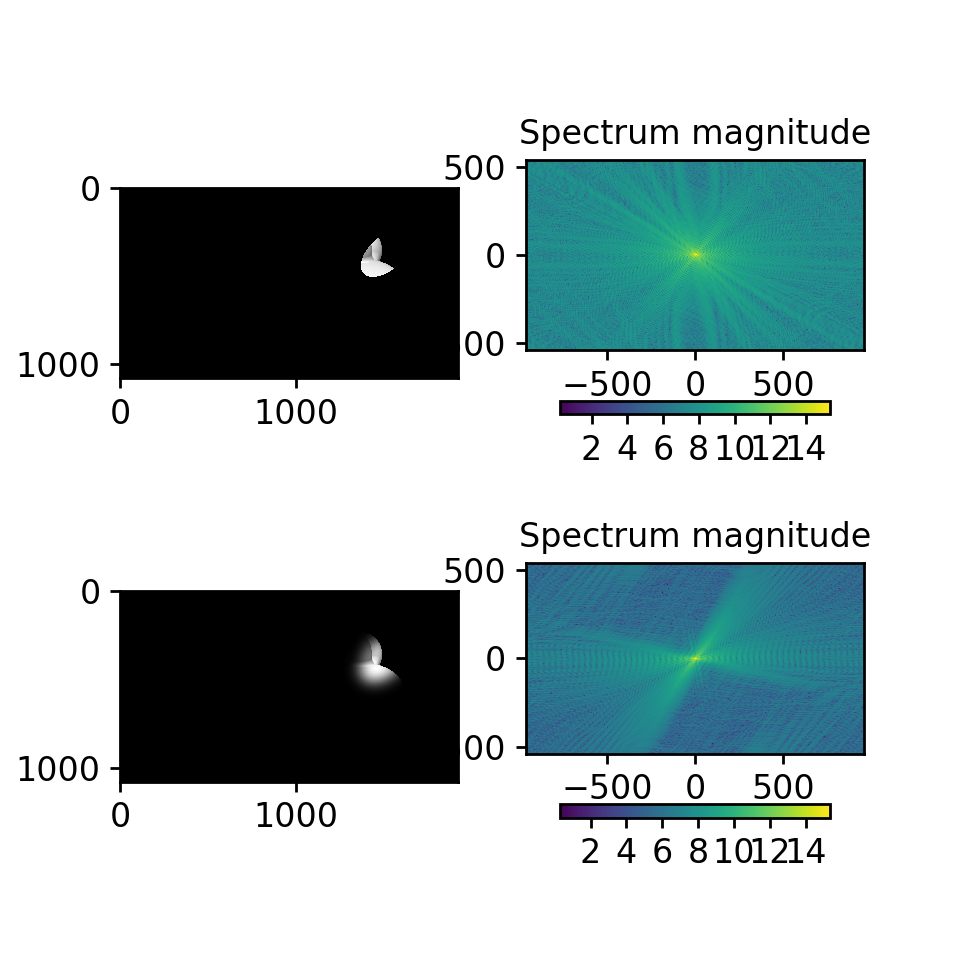

In [128]:
f, axn = pl.subplots(2, 2, figsize=(4.8, 4.8))
ax=axn[0, 0]
ax.imshow(result, cmap='gray')

ax=axn[0,1]
im=ax.imshow(np.log(1 + F_magnitude), cmap='viridis',
          extent=(-N // 2, N // 2, -M // 2, M // 2))
ax.set_title('Spectrum magnitude');
ax.set_aspect('equal')
pl.colorbar(im, ax=ax, shrink=0.8, orientation='horizontal')

ax=axn[1, 0]
ax.imshow(win_result, cmap='gray')

ax=axn[1, 1]
im=ax.imshow(np.log(1 + win_F_magnitude), cmap='viridis',
          extent=(-N // 2, N // 2, -M // 2, M // 2))
ax.set_title('Spectrum magnitude');
ax.set_aspect('equal')
pl.colorbar(im, ax=ax, shrink=0.8, orientation='horizontal')

<IPython.core.display.Javascript object>


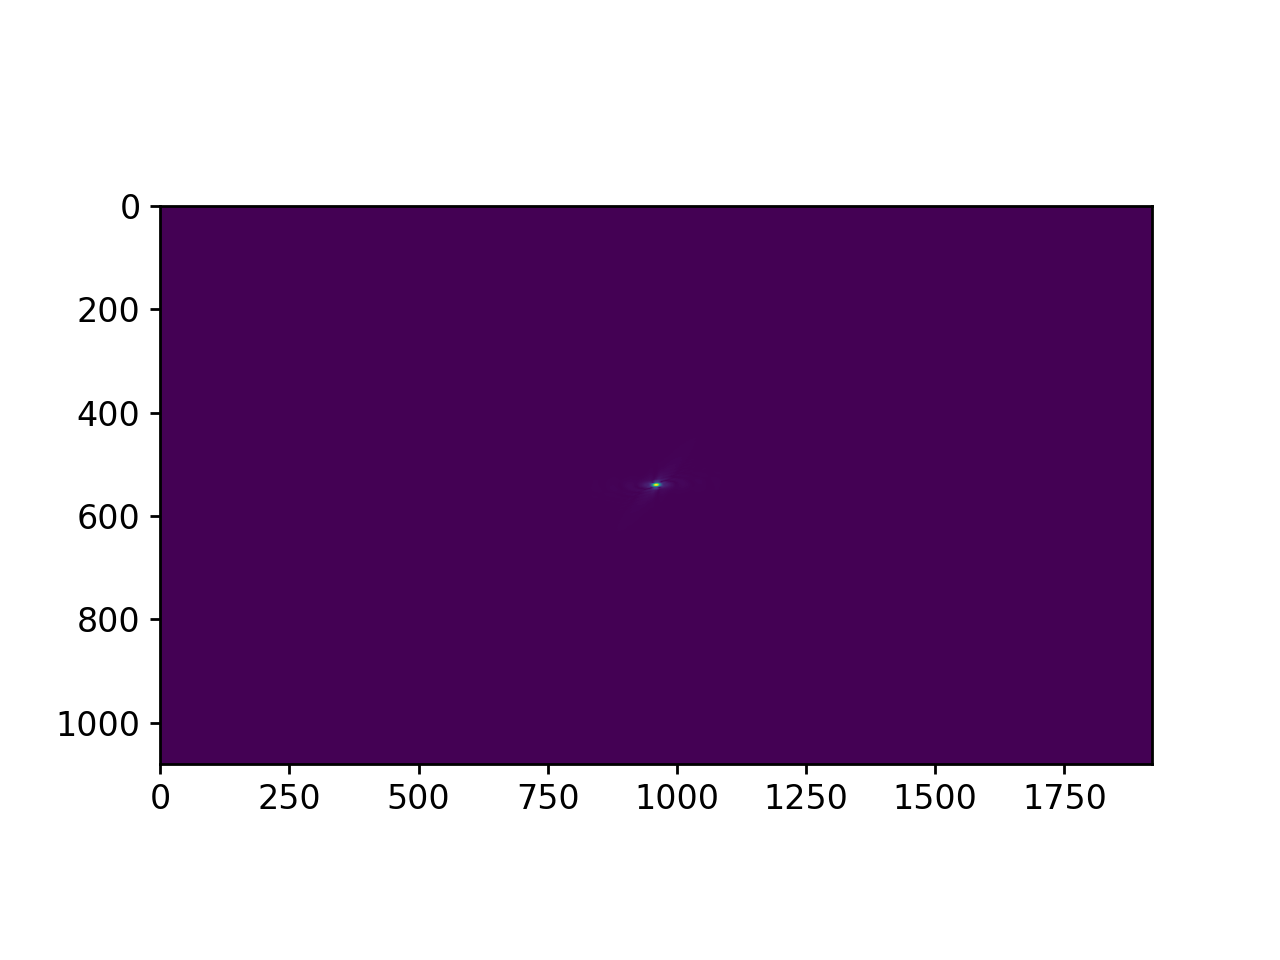

In [363]:
pl.figure()
pl.imshow(win_F_magnitude)

In [364]:
(-N // 2, N // 2, -M // 2, M // 2)

(-960, 960, -540, 540)

In [248]:

def tukey_twoD(width, height=None, alpha=0.5):
    """2D tukey lowpass window with a circular support
    """
    height=width if height is None else height
    base = np.zeros((width, height))
    tukey = signal.tukey(width, alpha)
    tukey = tukey[int(len(tukey)/2)-1:]  # Second half of tukey window
    x = np.linspace(-width/2, width/2, width)
    y = np.linspace(-height/2, height/2, height)
    
    #smol = max([width, height])
    for x_index in range(0, width):
        for y_index in range(0, height):
            # Only plot tukey value with in circle of radius width
            if int(np.sqrt(x[x_index]**2 + y[y_index]**2)) <= width/2:
                base[x_index, y_index] = tukey[int(np.sqrt(x[x_index]**2
                     + y[y_index]**2))]
                    # Based on k**2 find tukey window value and place in matrix
    return base

(320, 320)


<IPython.core.display.Javascript object>


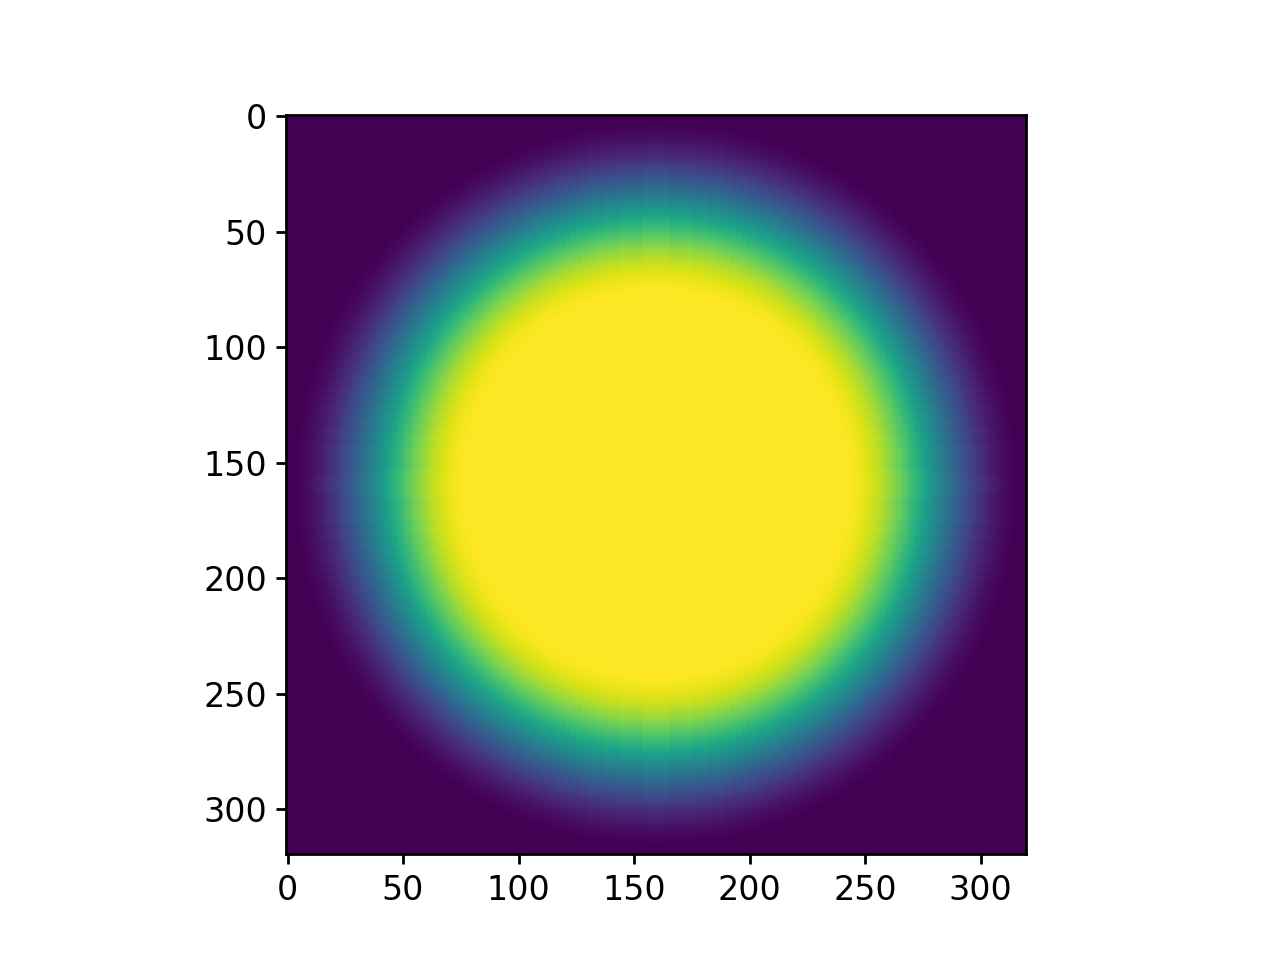

In [249]:
window = tukey_twoD(320, height=320, alpha=0.5) 
#signal.windows.tukey(max(bb_patch.shape))
print(window.shape)

pl.figure()
pl.imshow(window.T)
#pl.imshow(bb_patch, alpha=0.5)

In [112]:
image = img_as_float(rgb2gray(astronaut()))
image.dtype


dtype('float64')

In [124]:
bb_patch.shape

(242, 320)

<IPython.core.display.Javascript object>


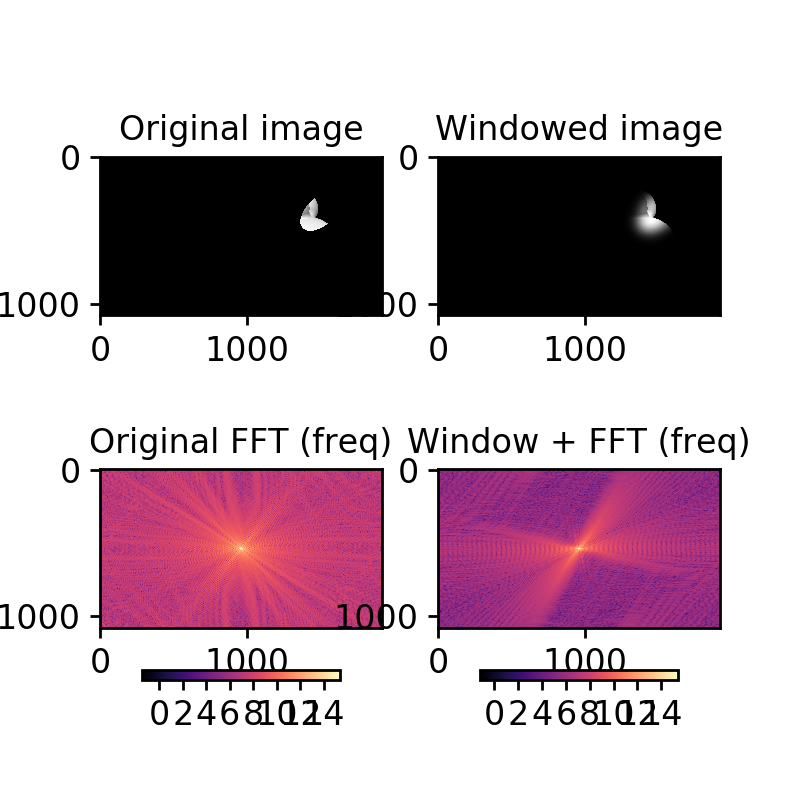

In [360]:
image_f = np.abs(fftpack.fftshift(fftpack.fft2(result)))
wimage_f = np.abs(fftpack.fftshift(fftpack.fft2(win_result)))

fig, axes = pl.subplots(2, 2, figsize=(4, 4))
axf = axes.ravel()
axf[0].set_title("Original image")
axf[0].imshow(result, cmap='gray')
axf[1].set_title("Windowed image")
axf[1].imshow(win_result, cmap='gray')

axf[2].set_title("Original FFT (freq)")
im0 = axf[2].imshow(np.log(image_f), cmap='magma')
pl.colorbar(im0, ax=axf[2], shrink=0.7, orientation='horizontal')
axf[3].set_title("Window + FFT (freq)")
im1 = axf[3].imshow(np.log(wimage_f), cmap='magma')
pl.colorbar(im1, ax=axf[3], shrink=0.7, orientation='horizontal')


<IPython.core.display.Javascript object>


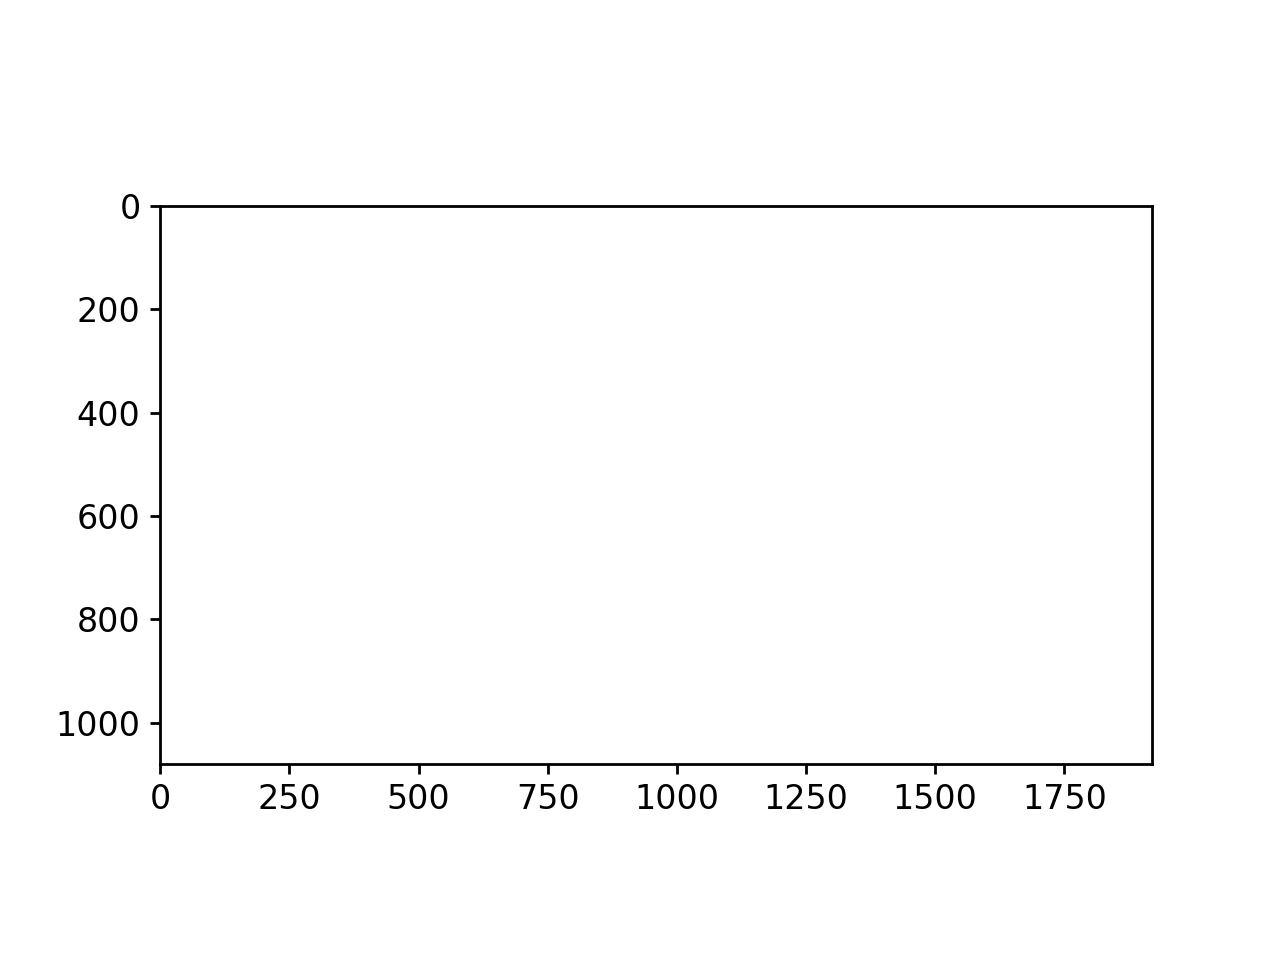

In [68]:

#import pylab as py

# Take the fourier transform of the image.
F1 = fftpack.fft2(rpatch)

# Now shift so that low spatial frequencies are in the center.
F2 = fftpack.fftshift( F1 )

# the 2D power spectrum is:
psd2D = np.abs( F2 )**2

# plot the power spectrum
pl.figure()
pl.imshow( psd2D )


In [359]:
F1.shape

(1080, 1920)

In [176]:
curr_rfs.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
0  0.693199  11.969817  22.030563  0.832975  34.263130 -10.628687    JC097   
2  0.849282  10.560903  21.094520  4.257285  30.957775  -9.201679    JC097   
3  0.756782  10.565565  21.694454  5.475640  12.538750   9.608165    JC097   
6  0.801322  18.984997  22.560555  4.675236  38.384916  -5.972743    JC097   
7  0.817732  10.430367  16.340641  0.480305  33.166237  -6.671661    JC097   

   cell              datakey experiment   ...      fwhm_avg   std_avg  \
0     0  20190616_JC097_fov1      rfs10   ...     17.000190  7.234123   
2     2  20190616_JC097_fov1      rfs10   ...     15.827711  6.735196   
3     3  20190616_JC097_fov1      rfs10   ...     16.130009  6.863834   
6     6  20190616_JC097_fov1      rfs10   ...     20.772776  8.839479   
7     7  20190616_JC097_fov1      rfs10   ...     13.385504  5.695959   

         area  datakey_ix  fov_xpos  fov_xpos_pix  fov_ypos  fov_ypos_pix  \
0  150.012430          10   99.0935            43   62.8227            33   
2  126.731578          10   103.703            45   119.934            63   
3  130.393390          10   126.748            55   112.319            59   
6  243.654517          10   142.879            62   70.4376            37   
7   96.957818          10   165.924            72   51.4004            27   

    ml_pos   ap_pos  
0  909.977  1078.51  
2  852.866   1073.9  
3  860.481  1050.85  
6  902.362  1034.72  
7    921.4  1011.68  

[5 rows x 25 columns]

# For all RFs measured, calculate overlap with stimuli

In [17]:
#### Calculate overlap with stimulus
stim_overlaps = dutils.calculate_overlaps(RFs, MEANS.keys(), experiment=experiment)


Stimuli presented at coords: (-5, 8)
Stimuli presented at coords: (15, 0)
Stimuli presented at coords: (20, -8)
Stimuli presented at coords: (20, -8)
Stimuli presented at coords: (20, -5)
Stimuli presented at coords: (10, -5)
---> (warning): no anatomicals for (JC091|20191008|FOV1_zoom2p0x)
Stimuli presented at coords: (20, -10)
Stimuli presented at coords: (30, -5)
Stimuli presented at coords: (30, -5)
Stimuli presented at coords: (25, -5)
Stimuli presented at coords: (-15, 0)
Stimuli presented at coords: (0, 5)
Stimuli presented at coords: (30, -5)
Stimuli presented at coords: (20, 0)
Stimuli presented at coords: (30, 8)
---> (warning): no anatomicals for (JC078|20190509|FOV1_zoom2p0x)
Stimuli presented at coords: (30, 8)
---> (warning): no anatomicals for (JC078|20190513|FOV1_zoom2p0x)
Stimuli presented at coords: (20, 0)
Stimuli presented at coords: (15, 8)
Stimuli presented at coords: (15, 8)
---> (warning): no anatomicals for (JC083|20190508|FOV1_zoom2p0x)
Stimuli presented at co

<IPython.core.display.Javascript object>


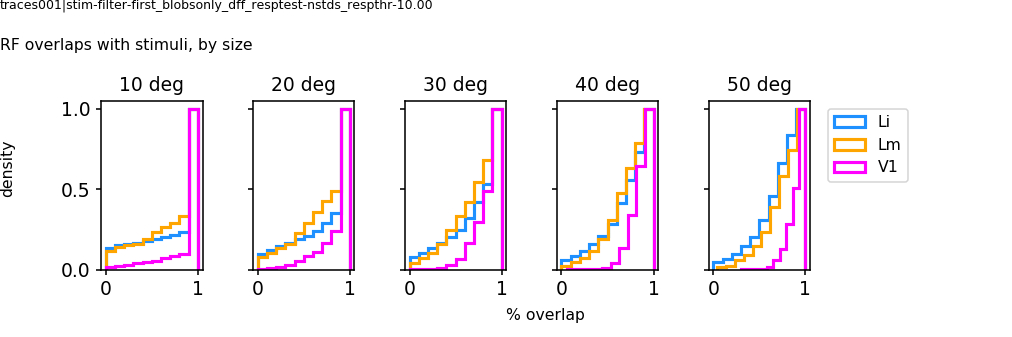

Text(0,0.85,u'RF overlaps with stimuli, by size')

In [22]:
# sns.catplot(x='visual_area', y='perc_overlap', col='stim_size', data=stim_overlaps,
#            kind='kdeplot', palette=area_colors, order=visual_areas)

fig, axn = pl.subplots(1, 5, figsize=(9, 3), sharex=True, sharey=True, dpi=dpi)
for ax, (sz, sg) in zip(axn.flat, stim_overlaps[['perc_overlap', 'visual_area', 'stim_size']].groupby(['stim_size'])):
    for v, vg in sg.groupby(['visual_area']):
        
        ax.hist(vg['perc_overlap'].values, color=area_colors[v], label=v,
                facecolor='none', edgecolor=area_colors[v], lw=2, alpha=1,
                density=True, cumulative=True, histtype='step')
    ax.set_title('%i deg' % (sz))
fig.text(0.5, 0.05, '% overlap')
fig.text(0.0, 0.5, 'density', rotation=90, va='center')

ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(wspace=0.5, top=0.7, right=0.8, bottom=0.2, left=0.1)

putils.label_figure(fig, data_id)
fig.text(0., 0.85, 'RF overlaps with stimuli, by size')

<IPython.core.display.Javascript object>


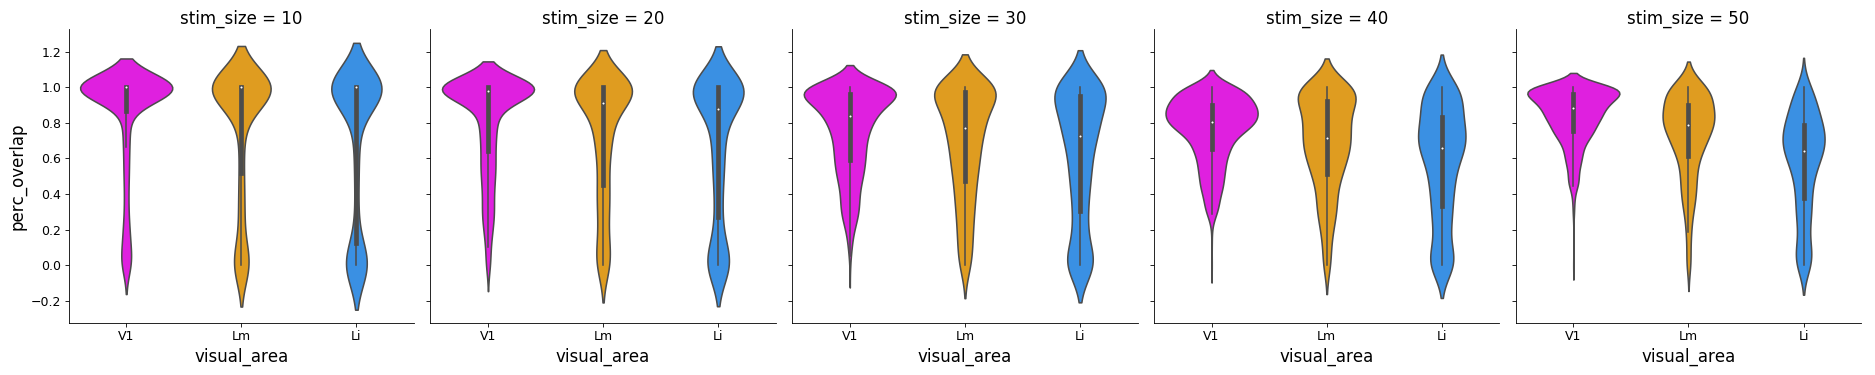

In [39]:
sns.catplot(x='visual_area', y='perc_overlap', col='stim_size', data=stim_overlaps,
           kind='violin', palette=area_colors, order=visual_areas)

# Get data common to RFs + blobs

In [18]:
# Get data common to RFs + blobs
c_list=[]
d_list = []
i=0
for (visual_area, datakey, rfname), g in stim_overlaps.groupby(['visual_area', 'datakey', 'rfname']):
    if datakey not in MEANS.keys():
        print("no %s: %s" % (experiment, datakey))
        continue

    exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
    rf_rids = sorted(g['cell'].unique())
    common_rids = np.intersect1d(exp_rids, rf_rids)
    print("[%s] %s, (%s) %i common cells" % (visual_area, datakey, rfname, len(common_rids)))
    c_list.append(pd.DataFrame({'visual_area': visual_area, 'datakey': datakey, 
                                'rfname': rfname, 'n_cells': len(common_rids)}, index=[i])) 
    d_list.append(g[g['cell'].isin(common_rids)].copy())
    i+=1    
rfs_and_blobs = pd.concat(d_list, axis=0)   
common_counts = pd.concat(c_list, axis=0)

[Li] 20190502_JC076_fov1, (rfs) 15 common cells
[Li] 20190602_JC091_fov1, (rfs10) 59 common cells
[Li] 20190605_JC090_fov1, (rfs10) 9 common cells
[Li] 20190606_JC091_fov1, (rfs10) 26 common cells
[Li] 20190607_JC091_fov1, (rfs10) 41 common cells
[Li] 20190609_JC099_fov1, (rfs10) 22 common cells
[Li] 20190612_JC099_fov1, (rfs10) 21 common cells
[Li] 20190614_JC091_fov1, (rfs10) 52 common cells
[Li] 20190617_JC099_fov1, (rfs10) 4 common cells
[Li] 20191008_JC091_fov1, (rfs10) 20 common cells
[Li] 20191018_JC113_fov1, (rfs10) 6 common cells
[Li] 20191105_JC117_fov1, (rfs10) 0 common cells
[Li] 20191111_JC120_fov1, (rfs10) 1 common cells
[Lm] 20190430_JC078_fov1, (rfs) 31 common cells
[Lm] 20190504_JC078_fov1, (rfs) 10 common cells
[Lm] 20190506_JC080_fov1, (rfs) 30 common cells
[Lm] 20190508_JC083_fov1, (rfs) 61 common cells
[Lm] 20190509_JC078_fov1, (rfs) 11 common cells
[Lm] 20190512_JC083_fov1, (rfs) 39 common cells
[Lm] 20190513_JC078_fov1, (rfs) 17 common cells
[Lm] 20190517_JC083_f

In [19]:
common_counts.groupby(['visual_area']).count()

datakey  n_cells  rfname
visual_area                          
Li                13       13      13
Lm                12       12      12
V1                11       11      11

In [20]:
overlap_int = 0.2
overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

for overlap_thr in overlap_thr_values:
    pdf = rfs_and_blobs[rfs_and_blobs['perc_overlap']>=overlap_thr].copy()
    print("----- Thr: %.2f --------------" % overlap_thr)
    print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

----- Thr: 0.00 --------------
             datakey  cell
visual_area               
Li               276   276
Lm               338   338
V1               736   736
----- Thr: 0.20 --------------
             datakey  cell
visual_area               
Li               264   264
Lm               337   337
V1               736   736
----- Thr: 0.40 --------------
             datakey  cell
visual_area               
Li               254   254
Lm               322   322
V1               736   736
----- Thr: 0.60 --------------
             datakey  cell
visual_area               
Li               248   248
Lm               302   302
V1               736   736
----- Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               241   241
Lm               272   272
V1               734   734
----- Thr: 1.00 --------------
             datakey  cell
visual_area               
Li               217   217
Lm               210   210
V1               664   664


# Set output dir

In [21]:
overlap_dir = os.path.join(decoding_dir, 'train-subset')
if not os.path.exists(overlap_dir):
    os.makedirs(overlap_dir)
print(overlap_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-subset


# Linear separability, by RF overlap

In [22]:
import scipy.stats as spstats
import sklearn.metrics as skmetrics
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
# from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm


In [23]:
import multiprocessing as mp
from functools import partial
from contextlib import contextmanager

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()
    pool.join()

def initializer(terminating_):
    # This places terminating in the global namespace of the worker subprocesses.
    # This allows the worker function to access `terminating` even though it is
    # not passed as an argument to the function.
    global terminating
    terminating = terminating_


def pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, n_iterations=50, n_processes=1,
                   test=None, single=False, n_train_configs=4):   
    '''
    test (string, None)
        None  : Classify A/B only (single=True to train/test on each size)
        morph : Train on anchors, test on intermediate morphs (single=True to train/test on each size)
        size  : Train on specific size(s), test on un-trained sizes (single=True to train/test on each size)
    '''
    
    results = []
    terminating = mp.Event()

    pool = mp.Pool(initializer=initializer, initargs=(terminating, ), processes=n_processes)  
    try:
        print("... n: %i (%i procs)" % (sample_ncells, n_processes))
        if test=='morph':
            if single: # train on 1 size, test on other sizes
                func = partial(dutils.do_fit_train_single_test_morph, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)
            else: # combine data across sizes
                func = partial(dutils.do_fit_train_test_morph, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)             
        elif test=='size':
            if single:
                func = partial(dutils.do_fit_train_test_single, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)
            else:
                func = partial(dutils.cycle_train_sets, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells, n_train_configs=n_train_configs)
        else:
            func = partial(dutils.do_fit, global_rois=global_rois, MEANS=MEANS, 
                           sdf=sdf, sample_ncells=sample_ncells)
        results = pool.map_async(func, range(n_iterations)).get(99999999)
        pool.close()
        pool.join()
    except KeyboardInterrupt:
        print("**interupt")
        pool.terminate()
        print("***Terminating!")
    finally:
        pool.close()
        pool.join()

    return results

In [24]:

# def do_fit_train_single_test_morph_FOV(iter_num, curr_data, sdf=None,
#                                cv=True, C_value=None, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106):
#     '''
#     Resample w/ replacement from pooled cells (across datasets). Assumes 'sdf' is same for all datasets.
#     Return fit results for 1 iteration.
#     Classes (class_a, class_b) should be the actual labels of the target (i.e., value of morph level)
#     '''
#     # Get new sample set
#     #curr_data = dutils.get_trials_for_N_cells(sample_ncells, global_rois, MEANS)

#     #### Select train/test configs for clf A vs B
#     class_types = [class_a, class_b]
#     restrict_transform = True
#     class_name='morphlevel'
#     constant_transform = 'size'
#     sizes = sorted(sdf[constant_transform].unique())
    
#     i_list=[]
#     i=0
#     # Go thru all training sizes, then test on non-trained sizes
#     for train_transform in sizes:

#         # Get train configs -- ANCHORS (A/B)
#         train_configs = sdf[(sdf[class_name].isin(class_types))
#                            & (sdf[constant_transform]==train_transform)].index.tolist()

#         #### TRAIN SET --------------------------------------------------------------------
#         # Get trial data for selected cells and config types
#         curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
#         trainset = curr_data[curr_data['config'].isin(train_configs)].copy()
#         train_data = trainset.drop('config', 1)#zdata = (data - data.mean()) / data.std()

#         # Get labels
#         targets = pd.DataFrame(trainset['config'].copy(), columns=['config'])
#         targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
#         targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

#         #### TEST SET --------------------------------------------------------------------
#         # Get data, specify configs
#         novel_class_types = [c for c in sdf[class_name].unique() if c not in class_types]
#         test_configs = sdf[(sdf[class_name].isin(novel_class_types))
#                           & (sdf[constant_transform]==train_transform)].index.tolist()
        
#         testset = curr_data[curr_data['config'].isin(test_configs)]
#         test_data = testset.drop('config', 1) #zdata = (data - data.mean()) / data.std()

#         # Get labels.
#         test_targets = pd.DataFrame(testset['config'].copy(), columns=['config'])
#         test_targets['label'] = [sdf['morphlevel'][cfg] for cfg in test_targets['config'].values]
#         test_targets['group'] = [sdf['size'][cfg] for cfg in test_targets['config'].values]

#         #### Train SVM ----------------------------------------------------------------------
#         iterdict, trained_svc, trained_scaler, (predicted_labels, true_labels) = dutils.fit_svm(train_data, targets, 
#                                                             return_clf=True, return_predictions=True,
#                                                             test_split=test_size, cv_nfolds=cv_nfolds, 
#                                                             cv=cv, C_value=C_value)
#         for anchor in [class_a, class_b]:
#             a_ixs = np.array([i for i, v in enumerate(true_labels) if v==anchor])
#             p_chooseB = sum([1 if p==class_b else 0 for p in predicted_labels[a_ixs]])/float(len(predicted_labels[a_ixs]))
#             iterdict.update({'p_chooseB': p_chooseB, 
#                              '%s' % class_name: anchor, 
#                              '%s' % constant_transform: train_transform})
#             i_list.append(pd.DataFrame(iterdict, index=[i]))
#             i+=1

#         #### Test SVM
#         for test_transform, curr_test_group in test_targets.groupby(['label']):
#             curr_test_data = test_data.loc[curr_test_group.index].copy()
#             curr_test_data = trained_scaler.transform(curr_test_data)

#             #### Calculate p choose B on trials where morph X shown (test_transform)
#             predicted_labels = trained_svc.predict(curr_test_data)
#             p_chooseB = sum([1 if p==class_b else 0 for p in predicted_labels])/float(len(predicted_labels))

#             iterdict.update({'p_chooseB': p_chooseB, 
#                              '%s' % class_name: test_transform,
#                              '%s' % constant_transform: train_transform})
            
#             i_list.append(pd.DataFrame(iterdict, index=[i]))
#             i+=1 
            
#     iterdf = pd.concat(i_list, axis=0).reset_index(drop=True)
#     iterdf['iteration'] = [iter_num for _ in np.arange(0, len(iterdf))]
    
#     return iterdf

# Set decoding params

In [31]:
test_size=0.2
cv_nfolds=5
cv=True

class_a=0
class_b=106
class_name='morphlevel'
constant_transform='size'

# Pool cells

In [33]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [29]:
not_in_means = [r for r in MEANS.keys() if r not in stim_datakeys] # all blobs
not_in_rfs = [r for r in rfs_and_blobs['datakey'].unique() if r not in stim_datakeys] # all blobs w/ RFs (kinda)
print(len(not_in_rfs), len(not_in_means))

(11, 12)


In [35]:
overlap_thr=0.8
filter_fovs = True
remove_too_few = False
min_ncells = 20 if remove_too_few else 0

# ------------------------------------------------------------------------------------
filter_str = 'filter-repeat-fovs' if filter_fovs else 'all-fovs'
filter_str = '%s_%s' % (filter_str, 'remove-few') if remove_too_few else filter_str
print(filter_str)

pooled_cells, cell_counts = dutils.get_pooled_cells(stim_datakeys, rfs_and_blobs, 
                                                     filter_fovs=filter_fovs, 
                                                     remove_too_few=remove_too_few, 
                                                     overlap_thr=overlap_thr, 
                                                     min_ncells=min_ncells)

# Make sure have SAME N trials total
keys_with_min_reps = [k for k in stim_datakeys 
                      if MEANS[k]['config'].value_counts().min() < 29]
filt_globaldf = pooled_cells[~pooled_cells['datakey'].isin(keys_with_min_reps)]
print(filt_globaldf[~filt_globaldf['datakey'].isin(keys_with_min_reps)]['visual_area'].value_counts())

print("--- final totals ---")
print(cell_counts)

sample_ncells = min(cell_counts.values())
print("Selecting %i cells for sample size" % sample_ncells)

filter-repeat-fovs
('V1', 650)
('Lm', 201)
('Li', 127)
V1    650
Lm    201
Li    112
Name: visual_area, dtype: int64
--- final totals ---
{'V1': 650, 'Lm': 201, 'Li': 127}
Selecting 127 cells for sample size


In [45]:
overlap_thr

0.8

In [41]:
rootdir='/n/coxfs01/2p-data'
animalid='JC097'
session = '20190616'
fov='FOV1_zoom2p0x'
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

In [ ]:
n_iterations = 100
n_train_configs = 4
n_processes=1

    
r_list=[]
for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):

    iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
                               test='size', single=False, n_train_configs=4,
                               n_iterations=n_iterations, n_processes=n_processes)
    iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)
    
    add_info = {'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area}
    iterdf = putils.add_meta_to_df(iterdf, add_info)

    r_list.append(iterdf)

results = pd.concat(r_list, axis=0).reset_index(drop=True)
print(r_list[0].shape, results.shape)


... n: 127 (1 procs)


In [36]:
dst_dir = os.path.join(decoding_dir, 'train-anchors')

<IPython.core.display.Javascript object>


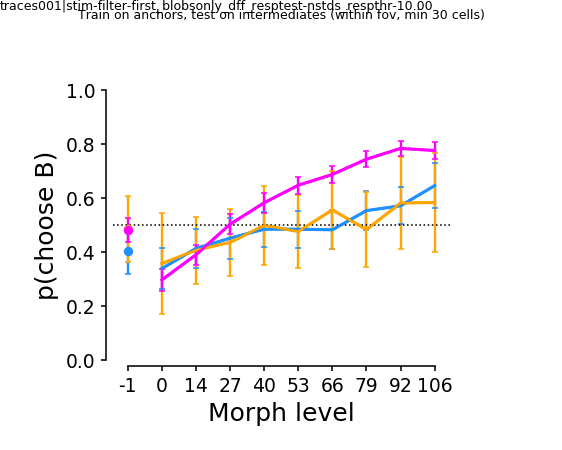

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors_by-FOV_min-30-cells_wLum')


In [46]:
ci=95
markersize=5
lw=2
capsize=2
plot_luminance=True
plot_ci=False
#shade=False
plot_str = 'wLum' if plot_luminance else ''
plot_str = '%s_ci%i' % (plot_str, ci) if plot_ci else plot_str

fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))
ax = plot_morph_curves(xdf, sdf, col_name='morphlevel', ci=ci, plot_luminance=plot_luminance, 
                      lw=lw, capsize=capsize, markersize=markersize, plot_ci=plot_ci,
                       area_colors=area_colors, ax=ax, dpi=dpi)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8)
ax.axhline(y=0.5, linestyle=':', color='k', lw=1)

sns.despine(trim=True, offset=4)
pl.suptitle("Train on anchors, test on intermediates (within fov, min %i cells)" % (min_ncells), fontsize=8)

putils.label_figure(fig, data_id)

figname = 'train-anchors_by-FOV_min-%i-cells_%s' % (min_ncells, plot_str)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [407]:
xdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

V1    10
Lm     7
Li     5
Name: visual_area, dtype: int64

#### Test space

In [120]:
iter_num=0
sample_ncells=200
global_rois = filt_globaldf[filt_globaldf['visual_area']=='V1']
iterdf = do_fit_train_single_test_morph(iter_num, global_rois=global_rois, MEANS=MEANS, sdf=sdf, 
                                 sample_ncells=sample_ncells,
                                 cv=True, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106)


In [123]:
iterdf.groupby(['size', 'morphlevel']).mean()['p_chooseB']

size  morphlevel
10.0  -1            0.206897
       0            0.600000
       14           0.379310
       27           0.517241
       40           0.620690
       53           0.517241
       66           0.517241
       79           0.586207
       92           0.482759
       106          0.857143
20.0  -1            0.965517
       0            0.125000
       14           0.379310
       27           0.620690
       40           0.586207
       53           0.793103
       66           0.793103
       79           0.758621
       92           0.862069
       106          0.750000
30.0  -1            0.586207
       0            0.375000
       14           0.379310
       27           0.586207
       40           0.724138
       53           0.724138
       66           0.655172
       79           0.758621
       92           0.862069
       106          0.750000
40.0  -1            0.517241
       0            0.166667
       14           0.379310
       27           0.5517

# RFECV

In [51]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [52]:
n_iterations = 100
d_list = []
for n in np.arange(0, n_iterations):
    if n%20==0:
        print("...%i of %i" % (n, n_iterations))
    for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):
        total_ncells = min(cell_counts.values()) #cell_counts[visual_area]

        curr_data = dutils.get_trials_for_N_cells(total_ncells, global_rois, MEANS)
        train_configs = sdf[sdf['morphlevel'].isin([class_a, class_b])].index.tolist()
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(train_configs)].copy()
        x = sample_data.drop('config', 1)
        zdata = StandardScaler().fit_transform(x)

        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])   
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]   
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

        # Create the RFE object and compute a cross-validated score.
        svc = SVC(kernel="linear", C=0.0001)

        # The "accuracy" scoring is proportional to the number of correct
        # classifications
        rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(cv_nfolds, shuffle=True, random_state=10),
                      scoring='accuracy')
        rfecv.fit(zdata, targets['label'].values)

        d_list.append(pd.DataFrame({'score': rfecv.grid_scores_,
                                    'visual_area': [visual_area for _ in np.arange(0, total_ncells)],
                                    'iteration': [n for _ in np.arange(0, total_ncells)]}))
rfe_df = pd.concat(d_list, axis=0)


...0 of 100


KeyboardInterrupt: 

In [ ]:
fig, ax = pl.subplots()
for visual_area, df_ in rfe_df.groupby(['visual_area']):
    total_ncells = cell_counts[visual_area]
    
    mean_scores = df_.mean()['score']
    sem_scores = df_.sem()['scores']
    
    # Plot number of features VS. cross-validation scores
    ax.plot(range(1, len(rfecv.grid_scores_) + 1), mean_scores, color=area_colors[visual_area], 
           lw=lw, label=visual_area)
    ax.fill_between(xvs, mean_scores-sem_scores, mean_scores+sem_scores, alpha=0.5, color=area_colors[visual_area])
    

ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score\n(# of correct classifications)")


In [197]:
rfecv.grid_scores_

(112,)

# Train on anchors, test on morphs (combine all sizes)

In [69]:

def plot_morph_curves(results, sdf, col_name='test_transform', plot_ci=False, ci=95, plot_luminance=True, lw=2, 
                      capsize=3, markersize=5, area_colors=None, ax=None, dpi=150, alpha=1, label=None):
    
    if area_colors is None:
        visual_areas, area_colors = putils.set_threecolor_palette()

    if ax is None:
        fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))

    morphlevels = sorted([s for s in sdf['morphlevel'].unique() if s!=-1])
    xvs = np.arange(1, len(morphlevels)+1) #if plot_luminance else np.arange(0, len(morphlevels))
    
    for visual_area, df_ in results.groupby(['visual_area']):
        
        if plot_luminance:
            # plot luminance control
            control_val=-1
            if plot_ci:
                ctl, ctl_lo, ctl_hi = dutils.calculate_ci(df_[df_[col_name]==control_val]['p_chooseB'].values, ci=ci)
                yerr = [abs(np.array([ctl-ctl_lo])), abs(np.array([ctl_hi-ctl]))]
            else:
                ctl = df_[df_[col_name]==control_val]['p_chooseB'].mean()
                yerr = df_[df_[col_name]==control_val]['p_chooseB'].sem()

            ax.errorbar(0, ctl, yerr=yerr, color=area_colors[visual_area],
                           marker='o', markersize=markersize, capsize=capsize, alpha=alpha)
            
        # plot morph curves
        if plot_ci:
            ci_vals = dict((val, dutils.calculate_ci(g['p_chooseB'].values, ci=ci)) \
                             for val, g in df_[df_[col_name].isin(morphlevels)].groupby([col_name]))
            mean_vals = np.array([ci_vals[k][0] for k in morphlevels])
            lowers = np.array([ci_vals[k][1] for k in morphlevels])
            uppers =  np.array([ci_vals[k][2] for k in morphlevels])
            yerr = [np.array([mean_vals - lowers]), np.array([mean_vals-uppers])]
        else:
            mean_vals = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).mean()['p_chooseB']
            yerr = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).sem()['p_chooseB']

        ax.plot(xvs, mean_vals, color=area_colors[visual_area], lw=lw, alpha=alpha, label=label)
        ax.errorbar(xvs, mean_vals, yerr=yerr, color=area_colors[visual_area],
                          capsize=capsize, alpha=alpha, label=None)


        ax.set_ylim([0, 1])

    xticks = np.arange(0, len(morphlevels)+1) if plot_luminance else xvs
    xlabels = sdf['morphlevel'].unique() if plot_luminance else sdf[sdf['morphlevel']!=-1]['morphlevel'].unique()
    ax.set_xticks(xticks)
    ax.set_xticklabels( [int(m) for m in sorted(xlabels)] )
    ax.set_ylabel('p(choose B)')
    ax.set_xlabel('Morph level')
    
    return ax


In [59]:
m0=0
m100=106
n_iterations=100
print(m0, m100, '%i iters' % n_iterations)

# CV stuff
cv=True
cv_nfolds=5
C_value=None
test_split=0.2

(0, 106, '100 iters')


In [66]:
sample_ncells=112

train_str = 'train-anchors-split-size_sample-%i_iter-%i' % (sample_ncells, n_iterations)
res_outfile = os.path.join(dst_dir, '%s_results.pkl' % train_str)
print(res_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results.pkl


In [61]:

r_list=[]
for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):

#     iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
#                                test_generalization=True, single=False, n_train_configs=4,
#                                n_iterations=n_iterations, n_processes=n_processes)
#     iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)
        
    iter_list=[]
    for iter_num in np.arange(0,  n_iterations):
        if iter_num%20==0:
            print("... (%s) %i of %i" % (visual_area, iter_num, n_iterations))   
        tmpdf = dutils.do_fit_train_single_test_morph(iter_num, global_rois=global_rois, MEANS=MEANS, sdf=sdf, 
                                     sample_ncells=sample_ncells,
                                     cv=True, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106)
        iter_list.append(tmpdf)
    iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)

    add_info = {'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area}
    iterdf = putils.add_meta_to_df(iterdf, add_info)

    r_list.append(iterdf)

results = pd.concat(r_list, axis=0).reset_index(drop=True)
print(r_list[0].shape, results.shape)



... (Li) 0 of 100
... (Li) 20 of 100
... (Li) 40 of 100
... (Li) 60 of 100
... (Li) 80 of 100
... (Lm) 0 of 100
... (Lm) 20 of 100
... (Lm) 40 of 100
... (Lm) 60 of 100
... (Lm) 80 of 100
... (V1) 0 of 100
... (V1) 20 of 100
... (V1) 40 of 100
... (V1) 60 of 100
... (V1) 80 of 100
((5000, 20), (15000, 20))


In [67]:
res_outfile = os.path.join(dst_dir, '%s_results2.pkl' % train_str)

# Save
print("Done!")
with open(res_outfile, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
print("Saved to: %s" % res_outfile)


Done!
Saved to: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results2.pkl


In [68]:
results.groupby(['visual_area', 'size', 'morphlevel']).mean()['p_chooseB']

visual_area  size  morphlevel
Li           10.0  -1            0.719655
                    0            0.329552
                    14           0.350690
                    27           0.397241
                    40           0.433793
                    53           0.374828
                    66           0.436897
                    79           0.633103
                    92           0.697931
                    106          0.601048
             20.0  -1            0.214483
                    0            0.298083
                    14           0.323793
                    27           0.371379
                    40           0.413103
                    53           0.366897
                    66           0.466897
                    79           0.580690
                    92           0.651724
                    106          0.623306
             30.0  -1            0.227931
                    0            0.239770
                    14           0.227586
    

In [98]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [99]:
train_str

'train-anchors-split-size_sample-112_iter-100'

<IPython.core.display.Javascript object>


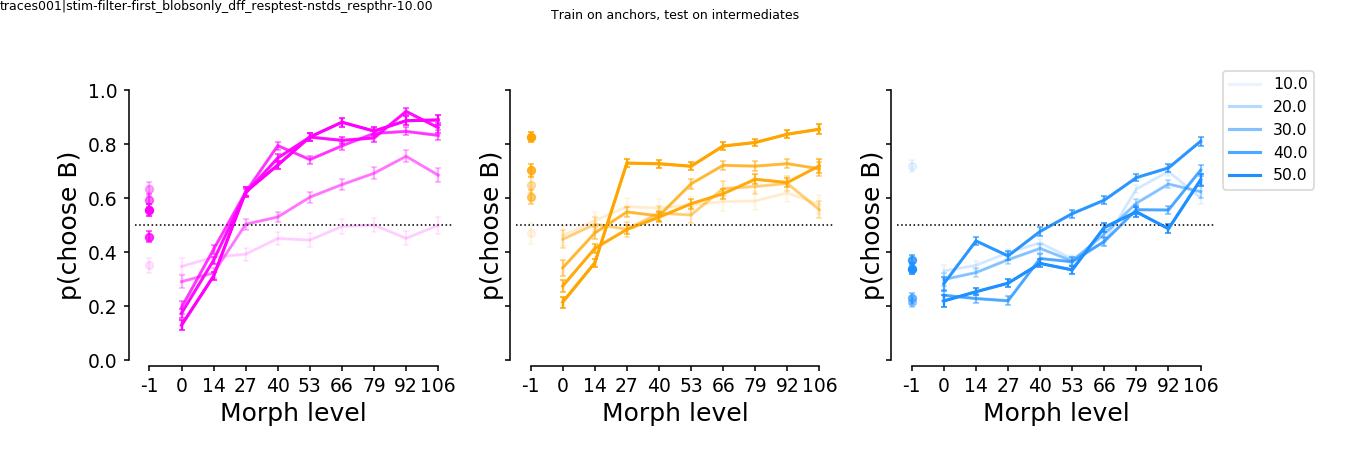

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors-split-size_sample-112_iter-100_overlap-0.80_morphcurves_split-size__wLum')


In [100]:
dutils.default_morphcurves_split_size(results, sdf, dst_dir=dst_dir, data_id=data_id, 
                                      train_str='%s_overlap-%.2f' % (train_str, overlap_thr))


<IPython.core.display.Javascript object>


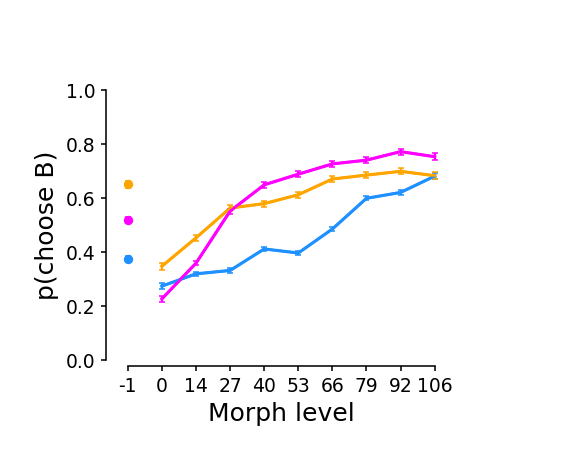

NameError: global name 'n_iterations' is not defined

In [101]:
dutils.default_morphcurves_avg_size(results, sdf, dst_dir=dst_dir, data_id=data_id, 
                                      train_str='%s_overlap-%.2f' % (train_str, overlap_thr))


# Train on subset, test on 1

In [329]:
# def plot_scores_by_test_set(results, ax=None):
#     if ax is None:
#         fig, ax = pl.subplots(dpi=dpi, figsize=(5,4), sharex=True, sharey=True)
#     sizes = [str(s) for s in sdf['size'].unique()]
#     markersize=5
#     for visual_area, vdf in results.groupby(['visual_area']):

#         mean_vals = vdf[vdf['test_transform'].isin(sizes)].groupby(['test_transform']).mean()[metric]
#         sem_vals = vdf[vdf['test_transform'].isin(sizes)].groupby(['test_transform']).sem()[metric]

#         ax.plot(np.arange(0, len(sizes)), mean_vals, color=area_colors[visual_area],
#                    marker='o', markersize=markersize, label=visual_area)
#         ax.errorbar(np.arange(0, len(sizes)), mean_vals, yerr=sem_vals, color=area_colors[visual_area],
#                    marker='o', markersize=markersize, label=None)

#         #ax.set_title(train_transform)
#         ax.axhline(y=0.5, color='k', linestyle=':')
#         ax.set_ylim([0.4, 1])
#         ax.set_xticks(np.arange(0, len(sizes)))
#         ax.set_xticklabels(sizes)

#     ax.set_xlabel('Test Size', fontsize=16)
#     ax.set_ylabel(metric, fontsize=16)
#     pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)
#     sns.despine(trim=True, offset=4)
#     ax.legend(bbox_to_anchor=(1, 1.1))
#     return ax

In [330]:
m0=0
m100=106
n_iterations=100
print(m0, m100, '%i iters' % n_iterations)

# CV stuff
cv=True
cv_nfolds=5
C_value=None
test_split=0.2

(0, 106, '100 iters')


In [331]:
n_train_configs=4
sample_ncells = 112

train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)

res_outfile = os.path.join(overlap_dir, '%s_results.pkl' % train_str)
do_fit = not os.path.exists(res_outfile)
if not do_fit:
    try:
        print("Results exist, loading...")
        with open(res_outfile, 'r') as f:
            results = pkl.load(f)
    except Exception as e:
        do_fit=True
print(do_fit)

Results exist, loading...
False


### Load or do

In [332]:
n_processes=1
if do_fit:
    r_list=[]
    for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):

        iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
                                   test_generalization=True, single=False, n_train_configs=4,
                                   n_iterations=n_iterations, n_processes=n_processes)

        iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)

        add_info = {'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area}
        iterdf = putils.add_meta_to_df(iterdf, add_info)

        r_list.append(iterdf)

    results = pd.concat(r_list, axis=0).reset_index(drop=True)
    print(r_list[0].shape, results.shape)
    
    # Save
    print("Done!")
    with open(res_outfile, 'wb') as f:
        pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

    print("Saved to: %s" % res_outfile)


### plot

In [375]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


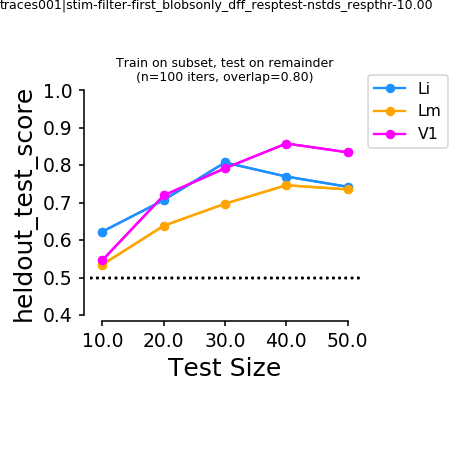

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_heldout_test_score_overlap-0.80_generalize_size')


<IPython.core.display.Javascript object>


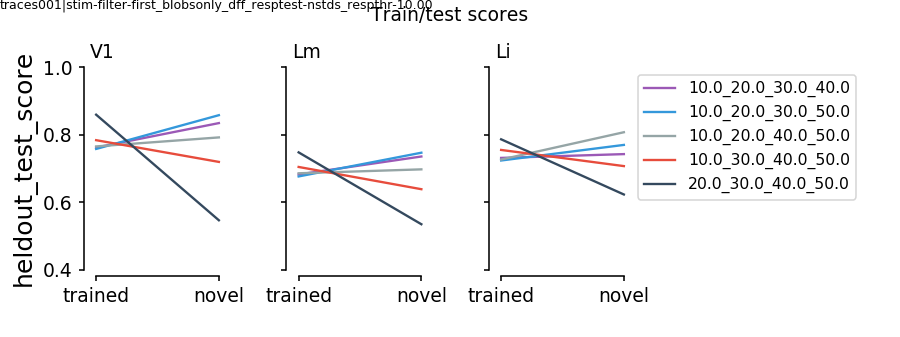

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_heldout_test_score_overlap-0.80_generalize_size__avg-novel-v-trained')


<IPython.core.display.Javascript object>


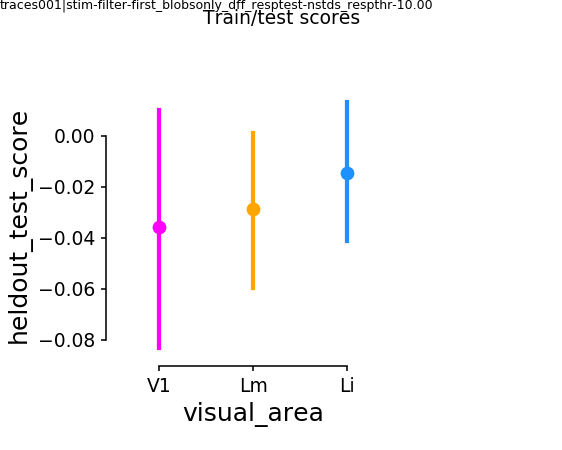

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_heldout_test_score_overlap-0.80_generalize_size__avg-novel-v-trained-difference')


In [376]:


metric = 'heldout_test_score'
plot_str = '%s_%s_overlap-%.2f' % (train_str, metric, overlap_thr)
plot_title = "Train on subset, test on remainder\n(n=%i iters, overlap=%.2f)" % (n_iterations, overlap_thr)

dutils.default_train_test_subset(results, sdf, metric=metric, 
                                 plot_title=plot_title, plot_str=plot_str, dst_dir=overlap_dir, data_id=data_id)


# Test by N cells

In [ ]:
sample_ncells = 112

train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)

res_outfile = os.path.join(overlap_dir, '%s_results.pkl' % train_str)
do_fit = not os.path.exists(res_outfile)
if not do_fit:
    try:
        print("Results exist, loading...")
        with open(res_outfile, 'r') as f:
            results = pkl.load(f)
    except Exception as e:
        do_fit=True
print(do_fit)

In [314]:
r_list = []
for visual_area, vdf in results.groupby(['visual_area']):
    for train_transform, traindf in vdf.groupby(['train_transform']):
        t_sizes = [t for t in sizes if t!=train_transform]
        
        curr_train_vals = traindf[traindf['test_transform']==train_transform][metric].values
        curr_iters = traindf[traindf['test_transform']==train_transform]['iteration'].values
        for test_transform in t_sizes:
            curr_test_vals = traindf[traindf['test_transform']==test_transform][metric].values
            rel_scores = (curr_test_vals/curr_train_vals) #* curr_train_vals
            
            reldf = pd.DataFrame({metric: rel_scores,
                                  'iteration': curr_iters})
            
            add_info = {'visual_area': visual_area, 'train_transform': train_transform, 
                        'test_transform': test_transform}
            reldf = putils.add_meta_to_df(reldf, add_info)
            r_list.append(reldf)
relative_df = pd.concat(r_list, axis=0).reset_index(drop=True) 

In [315]:
relative_means = relative_df.groupby(['visual_area', 'train_transform', 'test_transform']).mean().reset_index()



<IPython.core.display.Javascript object>


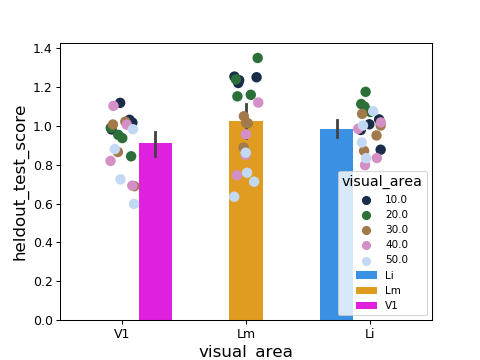

In [317]:
visual_areas=['V1', 'Lm', 'Li']
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y=metric, hue='train_transform', data=relative_means, ax=ax,
             order=visual_areas, palette='cubehelix', s=10)
sns.barplot(x='visual_area', y=metric, hue='visual_area', data=relative_means, ax=ax,
             order=visual_areas, palette=area_colors)

<IPython.core.display.Javascript object>


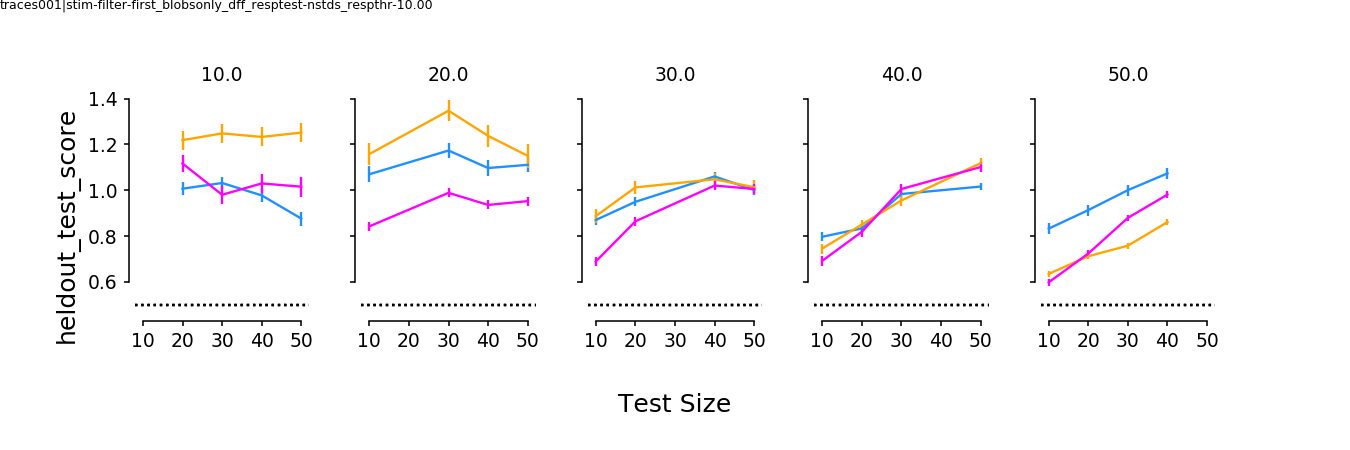

In [289]:
# Plot.

fig, axn = pl.subplots(1, 3, dpi=dpi, figsize=(12,4), sharex=True, sharey=True)

for visual_area, vdf in relative_df.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)

    mean_vals = vdf.groupby(['train_transform', 'test_transform']).mean().groupby(['train_transform']).mean()[metric]
    sem_vals = vdf.groupby(['train_transform', 'test_transform']).mean().groupby(['train_transform']).sem()[metric]

    
        currdf = traindf.groupby(['test_transform']).mean().reset_index()
        currdf_sem = traindf.groupby(['test_transform']).sem().reset_index()

        xv = sorted(currdf['test_transform'].values)
        yv = currdf.sort_values(by='test_transform')['%s' % metric].values
        yv_err = currdf_sem.sort_values(by='test_transform')['%s' % metric].values

        #train_index = xv.index(train_transform)

        ax.errorbar(xv, yv, yerr=yv_err, color=area_colors[visual_area])
#         ax.errorbar(xv[train_index], yv[train_index], yerr=yv_err[train_index], color=area_colors[visual_area],
#                    marker='o', markersize=10)

        ax.set_title(train_transform)
        ax.axhline(y=0.5, color='k', linestyle=':')
        #ax.set_ylim([0.4, 1])
        ax.set_xticks(sizes)
        ax.set_xticklabels([int(s) for s in sizes])
    
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)

putils.label_figure(fig, data_id)

# figname = 'generalize_size_%s__ncells-%i_overlap-%.2f_%i-iter' % (metric, sample_ncells, overlap_thr, n_iterations)
# pl.savefig(os.path.join(overlap_dir, '%s.svg' % figname))
# print(overlap_dir, figname)

In [61]:
rfs_and_blobs[(rfs_and_blobs['datakey'].isin(stim_datakeys)) 
             & (rfs_and_blobs['perc_overlap']>=overlap_thr)][['visual_area', 'datakey', 'cell']].drop_duplicates()['visual_area'].value_counts()

V1    650
Lm    201
Li    127
Name: visual_area, dtype: int64

In [ ]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')

overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)



# Test generalization

In [38]:
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

NameError: name 'animalid' is not defined

In [1156]:
overlap_thr=0.8
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 


-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)


In [1230]:
from sklearn.model_selection import StratifiedKFold

In [1456]:
n_iterations = 3